Diego García Maroto (diegar20@ucm.es)

# Práctica 2: Análisis de extremos, análisis espectral y filtros

In [382]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

# Estadística
from scipy import stats 
from scipy import special
from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

Vamos a calcular los siguientes indices de extremos:

![title](./img/index.png)

Lectura de datos (necesitaremos tanto Tmax como Tmin):

In [383]:
path = './data/'
file_max = 'tmax_pen.nc'
data_max = xr.open_dataset(path+file_max)
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)
display(data_max)
data_min

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tx       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily maximum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, maximum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tn       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily minimum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, minimum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

In [384]:
# Separamos las variables (las lat y lon son las mismas al ser la misma base de datos)
lon = data_min.lon
lat = data_min.lat
tmin = data_min.tn
tmax = data_max.tx
display(tmax)
display(tmin)

<xarray.DataArray 'tx' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Maximum temperature

<xarray.DataArray 'tn' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

---

## Calculamos las Cold Nights:

In [385]:
# Defino funciones para calcular el índice y los percentiles mediante el módulo xclim
def cold_nights_xclim(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time 
    except: 
        tmin = tmin.rename({'Time': 'time'}) # Para que funcione bien con el módulo, la variable tiempo debe llamarse time
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC' # La unidad de grados debe nombrarse así
    base = tmin.sel(time=slice(ref_period[0],ref_period[1])) # Periodo de referencia 
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10) # Percentiles por cada día del año
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per) # Número de noches frías en cada año
    percent_cold_nights = num_cold/365*100 # Lo pasamos de número de días a porcentaje 
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: 
        tmax.time
    except: 
        tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice(ref_period[0],ref_period[1])) # Periodo de referencia 
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tx10p(tmax.sel(time=slice(period[0],period[1])), tmax_per)
    percent_cold_days = num_cold/365*100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days


Primero para la región del oeste:

In [386]:
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tminO = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try: # Como el cálculo es costoso, después de la primera vez, guardo los resultados en un fichero. Por eso lo primero que hago es buscarlo para tratar de leerlo de allí.
    tmin_p10_O = xr.open_dataarray('./outs/tmin_p10_O.nc')
    percent_cold_nights_O = xr.open_dataarray('./outs/percent_cold_nights_O.nc')
    print('Leido de outs')
except: # Si no encuentra el fichero hace el cálculo de cero y lo intenta guardar en un fichero.
    tmin_p10_O, percent_cold_nights_O = cold_nights_xclim(tminO,['1901','2014'])
    tmin_p10_O.to_netcdf('./outs/tmin_p10_O.nc')
    percent_cold_nights_O.to_netcdf('./outs/percent_cold_nights_O.nc')
display(tmin_p10_O)
display(percent_cold_nights_O)

Leido de outs


<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
[746640 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-20 01:36:07] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
[232560 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

Hago lo mismo para el resto de regiones:

In [387]:
try: 
    tmin_p10_E = xr.open_dataarray('./outs/tmin_p10_E.nc')
    percent_cold_nights_E = xr.open_dataarray('./outs/percent_cold_nights_E.nc')
    print('Leido de outs')
except:
    tmin_p10_E, percent_cold_nights_E = cold_nights_xclim(tmin.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmin_p10_E.to_netcdf('./outs/tmin_p10_E.nc')
    percent_cold_nights_E.to_netcdf('./outs/percent_cold_nights_E.nc')

Leido de outs


In [388]:
try: 
    tmin_p10_C = xr.open_dataarray('./outs/tmin_p10_C.nc')
    percent_cold_nights_C = xr.open_dataarray('./outs/percent_cold_nights_C.nc')
    print('Leido de outs')
except:
    tmin_p10_C, percent_cold_nights_C = cold_nights_xclim(tmin.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmin_p10_C.to_netcdf('./outs/tmin_p10_C.nc')
    percent_cold_nights_C.to_netcdf('./outs/percent_cold_nights_C.nc')

Leido de outs


In [389]:
try: 
    tmin_p10_S = xr.open_dataarray('./outs/tmin_p10_S.nc')
    percent_cold_nights_S = xr.open_dataarray('./outs/percent_cold_nights_S.nc')
    print('Leido de outs')
except:
    tmin_p10_S, percent_cold_nights_S = cold_nights_xclim(tmin.sel(lat=slice(38,36),lon=slice(-8, 0)),['1901','2014'])
    tmin_p10_S.to_netcdf('./outs/tmin_p10_S.nc')
    percent_cold_nights_S.to_netcdf('./outs/percent_cold_nights_S.nc')


Leido de outs


In [390]:
try: 
    tmin_p10_N = xr.open_dataarray('./outs/tmin_p10_N.nc')
    percent_cold_nights_N = xr.open_dataarray('./outs/percent_cold_nights_N.nc')
    print('Leido de outs')
except:
    tmin_p10_N, percent_cold_nights_N = cold_nights_xclim(tmin.sel(lat=slice(43.8,42.5),lon=slice(-6,0)),['1901','2014'])
    tmin_p10_N.to_netcdf('./outs/tmin_p10_N.nc')
    percent_cold_nights_N.to_netcdf('./outs/percent_cold_nights_N.nc')


Leido de outs


Voy a pintar las regiones de España que estamos usando, para visualizarlas mejor:

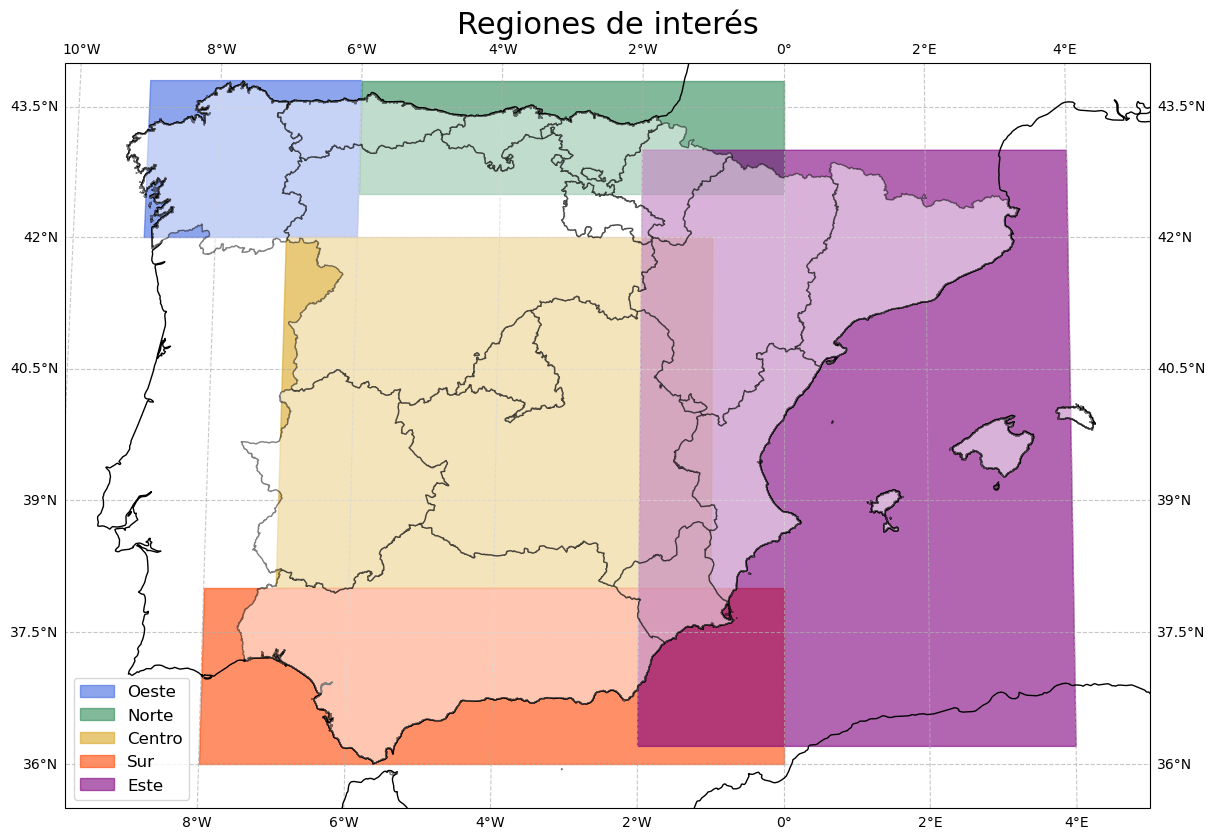

In [391]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = './mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

fig, ax = plt.subplots(figsize=(14, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.Robinson())


# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='w', alpha=0.5)

ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes



def pinta_region(lats,lons,color,ax=ax,label=None,fill=True,lw=1):
    '''Esta función nos servirá para pintar rectángulos con las regiones'''
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=fill, lw=lw, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)

# Pinto las 5 regiones
ax.set_title('Regiones de interés',size=22)
pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')


ax.legend(prop={'size':12})
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot
#fig.savefig('mapa_regiones_ESP.png',dpi=600,facecolor='w')

Una vez obtenidas las series para cada una de las regiones para el periodo completo, pintamos el promedio temporal en el mapa de España:

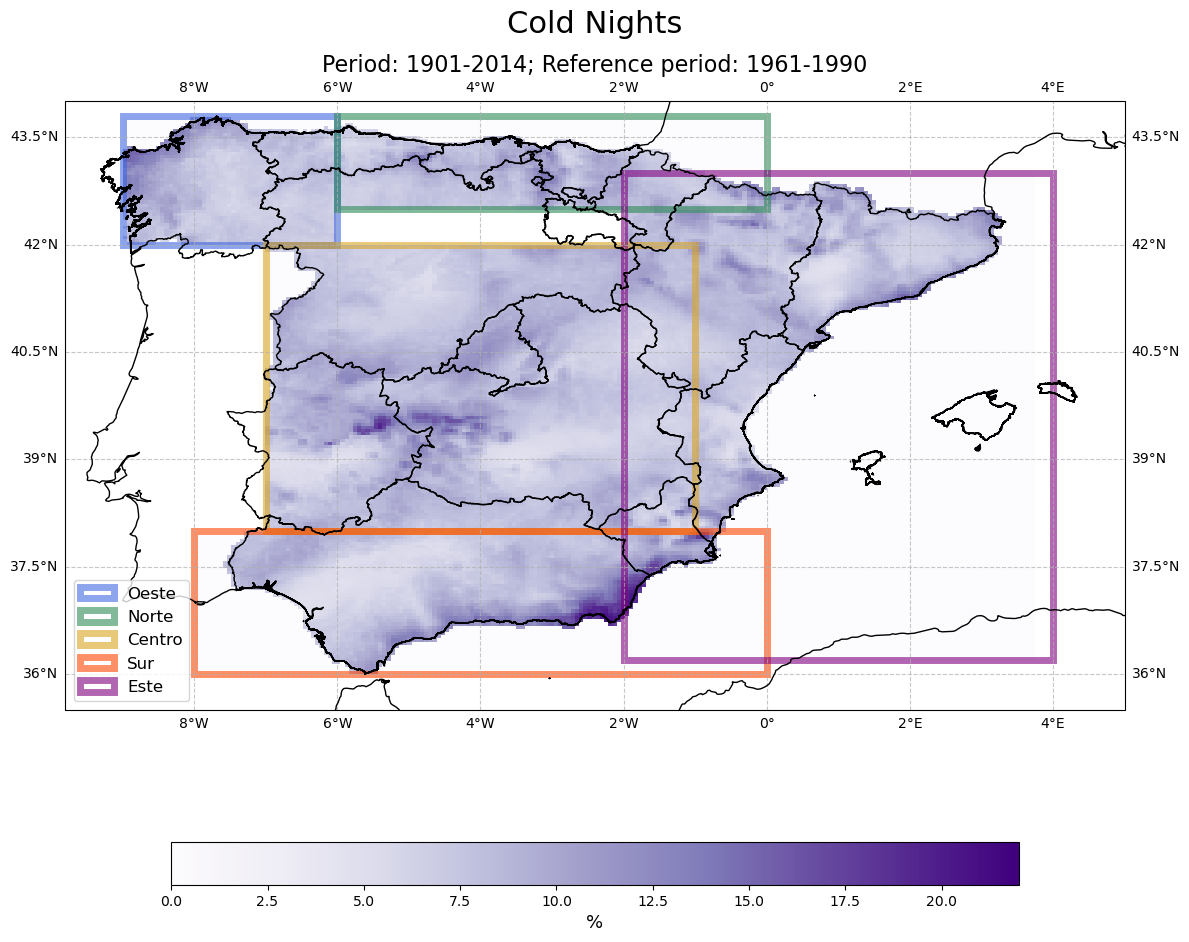

In [392]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = './mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Nights',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)


# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)

ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# A partir de aquí vamos a pintar los valores promedio de noches frías en el periodo empleado   
cmap = 'Purples'

var = percent_cold_nights_O.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 
#print(var.max().squeeze())

var = percent_cold_nights_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
#print(var.max().squeeze())

var = percent_cold_nights_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
#print(var.max().squeeze())


var = percent_cold_nights_S.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
#print(var.max().squeeze())


var = percent_cold_nights_N.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
#print(var.max().squeeze())

# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8) 
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22) # Al poner los mismos vmin y vmax aseguramos que la escala sea consistente en cada parte


# Ahora pintamos las regiones (solo cuadrados sin relleno) 
pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste',fill=False,lw=5)
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte',fill=False,lw=5)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro',fill=False,lw=5)
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur',fill=False,lw=5)
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este',fill=False,lw=5)

ax.legend(prop={'size':12})
plt.tight_layout()

In [393]:
#fig.savefig('cold_nights2.png',dpi=600,facecolor='w')

Vamos a ver si ha habido cambios en el índice, dividiéndolo en dos periodos:

Mapa de diferencias:

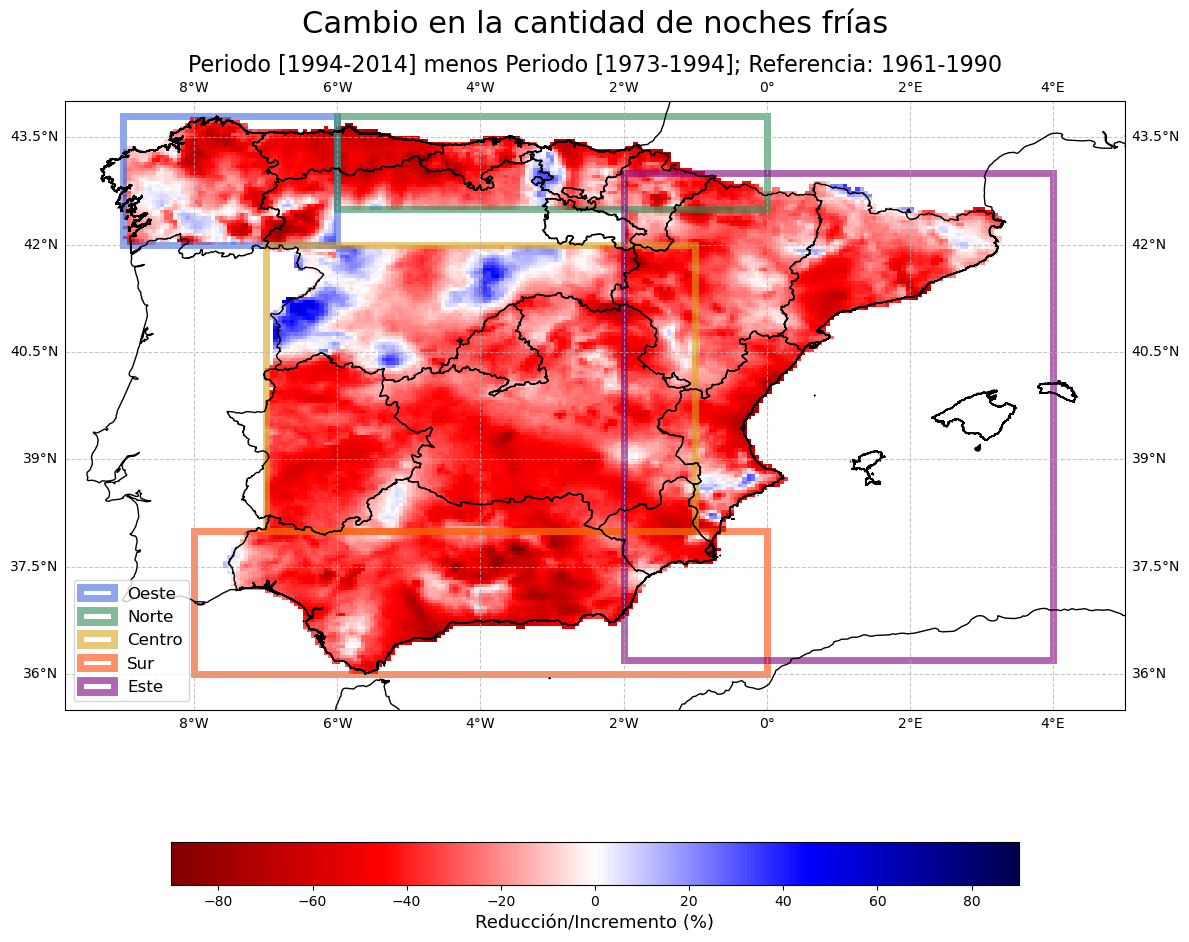

In [394]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = './mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cambio en la cantidad de noches frías',size=22)
plt.title('Periodo [1994-2014] menos Periodo [1973-1994]; Referencia: 1961-1990',size=16)

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90

# Vamos a calcular la diferencia entre los dos periodos y dividirla entre el primero para obtener incrementos relativos en porcentaje
var = (percent_cold_nights_O.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_O.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_O.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
# print(var.max().squeeze())

var = (percent_cold_nights_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
# print(var.max().squeeze())

var = (percent_cold_nights_C.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_C.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_C.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) 
# print(var.max().squeeze())


var = (percent_cold_nights_S.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_S.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_S.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
# print(var.max().squeeze())


var = (percent_cold_nights_N.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_N.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_N.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
# print(var.max().squeeze())

# Barra de color
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)

# Ahora pintamos las regiones (solo cuadrados sin relleno) 
pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste',fill=False,lw=5)
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte',fill=False,lw=5)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro',fill=False,lw=5)
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur',fill=False,lw=5)
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este',fill=False,lw=5)

ax.legend(prop={'size':12})
plt.tight_layout()

In [395]:
#fig.savefig('cambios_nights.png',dpi=600,facecolor='w')

Ahora vamos a representar las series temporales:

In [396]:
from matplotlib import style

def series_style():
    ''' Hago una función para poner los ajustes que quiero usar para todas las gráficas que no sean mapas '''
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)

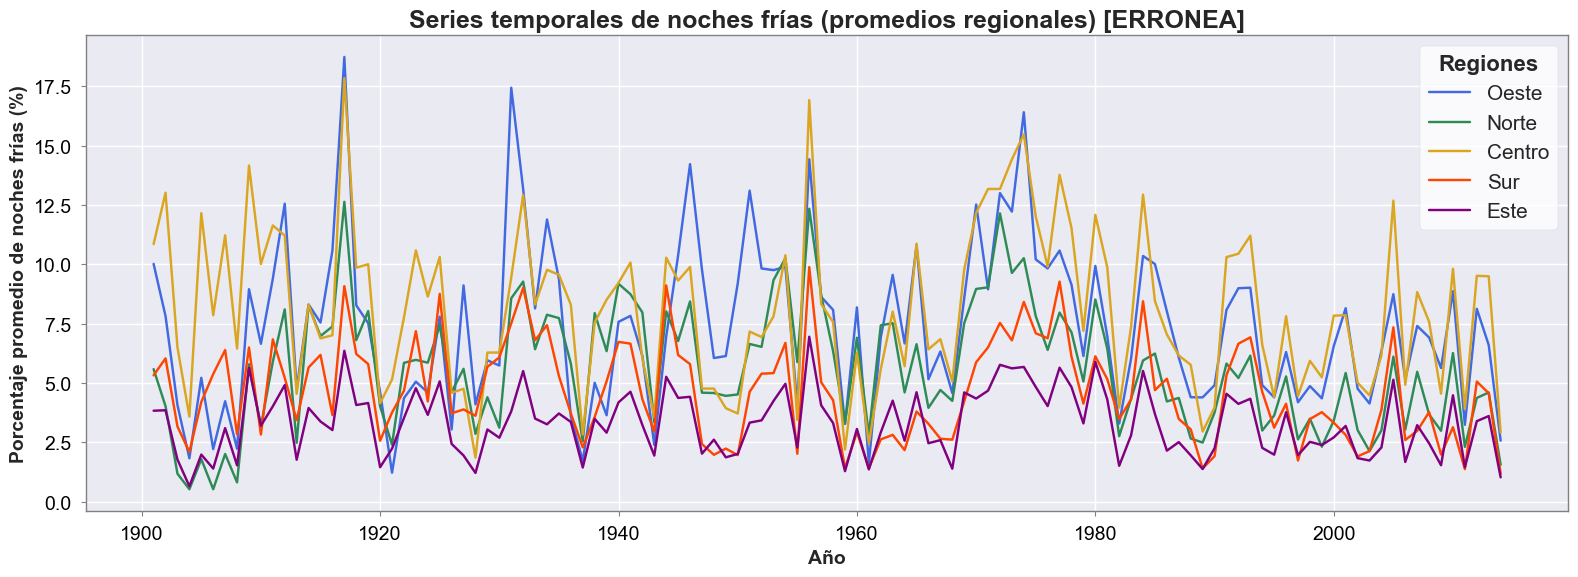

In [397]:
# Pinto las series promediando todas las latitudes y longitudes 
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,percent_cold_nights_O.mean(dim=['lon','lat']),color='royalblue',label='Oeste')
ax.plot(años,percent_cold_nights_N.mean(dim=['lon','lat']),color='seagreen',label='Norte')
ax.plot(años,percent_cold_nights_C.mean(dim=['lon','lat']),color='goldenrod',label='Centro')
ax.plot(años,percent_cold_nights_S.mean(dim=['lon','lat']),color='orangered',label='Sur')
ax.plot(años,percent_cold_nights_E.mean(dim=['lon','lat']),color='purple',label='Este')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales) [ERRONEA]')
plt.tight_layout()

In [398]:
display(percent_cold_nights_O)

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      , 10.684932, ...,  5.753425,  5.479452],
        [ 0.      ,  9.589041, ...,  6.027397,  6.849315]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  8.493151, ...,  7.123288,  6.027397],
        [ 0.      ,  8.219178, ...,  8.219178,  7.123288]],

       ...,

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  5.479452, ..., 13.150685, 14.794521],
        [ 0.      ,  5.479452, ..., 13.972603, 14.794521]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  1.09589 , ...,  6.849315,  6.575342],
        [ 0.      ,  0.547945, ...,  6.575342,  6.849315]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

Viendo las series, observamos que están correlacionadas pero que algunas tienen una escala mucho menor. La causa parece ser que en las zonas de océano donde no hay datos al calcular el índice los nan se sustituyen por 0, así al hacer promedios donde más océano había más se infraestima la serie.

Hay que corregirlas, volver a poner los nan en las zonas de océano (si no se infravalora el porcentaje):

In [399]:
def correct_series(percent,tmin=tmin,freq='YS'):
    '''El objetivo de esta función es volver a colocar los np.nan en las posiciones del cuadrado de lat y lon donde 
    no tenemos datos. Al calcular el índice de extremos esos puntos han quedado con 0. Esto hace que al promediar esas
    dimensiones infraestimemos la media.
    
    Defino dos posibles frecuencias porque luego la usaré para corregir series mensuales.
    
    La idea es coger los nan de un array que sepa que los tiene bien colocados (como el propio array de tmin) y usarlo para generar uno nuevo con np.where().
    '''
    tmin = tmin.rename({'Time': 'time'})
    if freq=='YS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=((tminR.time.dt.month == 6) & (tminR.time.dt.day == 1)))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])
        result = corr_R_x.mean(dim=['lon','lat'])


    if freq=='MS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=(tminR.time.dt.day == 10))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])

        result = corr_R_x.mean(dim=['lon','lat'])

    return result

In [400]:
corr_E = correct_series(percent_cold_nights_E)

In [401]:
corr_N = correct_series(percent_cold_nights_N)

In [402]:
corr_S = correct_series(percent_cold_nights_S)

In [403]:
corr_O = correct_series(percent_cold_nights_O)

In [404]:
corr_C = correct_series(percent_cold_nights_C)

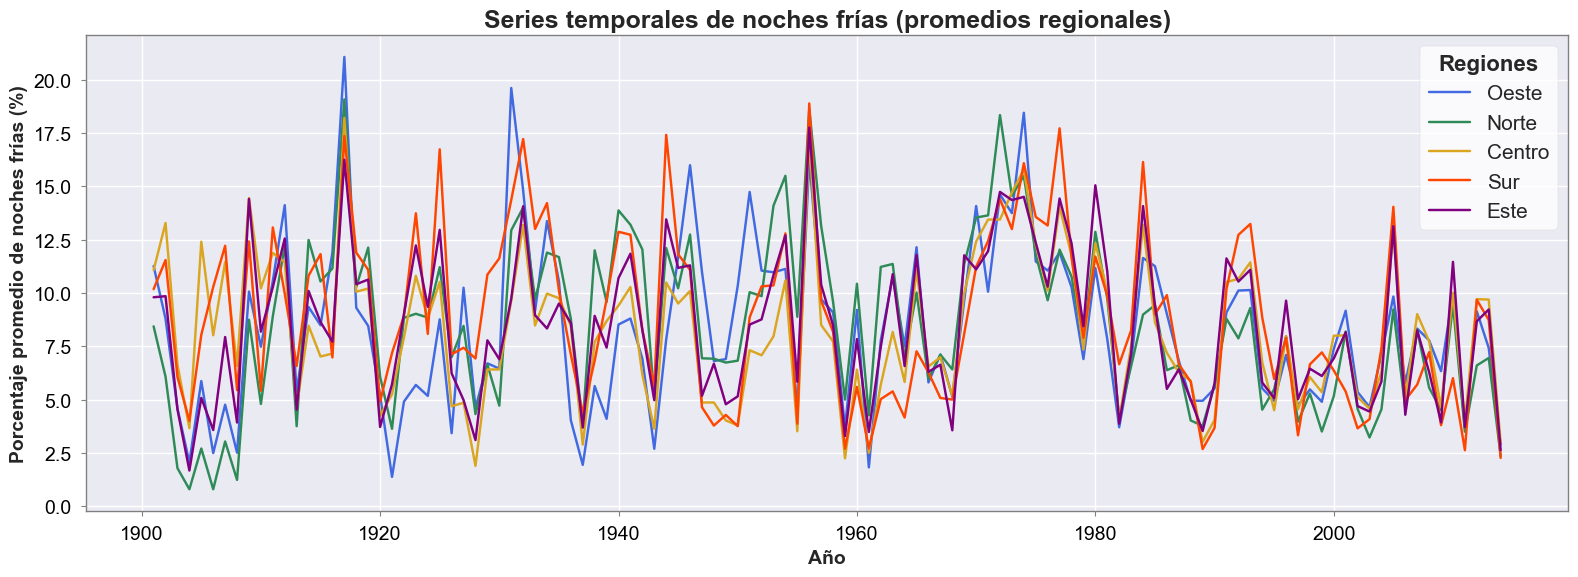

In [405]:
# Ahora representamos las series corregidas 
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O,color='royalblue',label='Oeste')
ax.plot(años,corr_N,color='seagreen',label='Norte')
ax.plot(años,corr_C,color='goldenrod',label='Centro')
ax.plot(años,corr_S,color='orangered',label='Sur')
ax.plot(años,corr_E,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

In [406]:
#fig.savefig('series_reg.png',dpi=600,facecolor='w')

In [407]:
# Calculo la media y la guardo porque será util más adelante
tminOm = tminO.mean(dim=['lon','lat'],keep_attrs=True)
tminOm

<xarray.DataArray 'tn' (Time: 41638)>
array([ 2.3032253 ,  1.679131  ,  1.7624679 , ..., -1.5089166 ,
       -1.5696096 , -0.08151622], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

A partir de aquí hasta el siguiente apartado, es solo un chequeo de si importa o no cuando hagamos el promedio regional (antes o después de calcular el índice):

In [408]:
tminOm = tminOm.rename({'Time': 'time'})
tminOm.attrs['units'] = 'degC'

In [409]:
basem = tminOm.sel(time=slice('1961','1990'))
basem

<xarray.DataArray 'tn' (time: 10957)>
array([2.3487177 , 0.86258835, 2.015206  , ..., 3.645706  , 5.783328  ,
       5.418103  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 1990-12-31
Attributes:
    units:      degC
    long_name:  Minimum temperature

In [410]:
tas_perm = percentile_doy(basem, per=10).sel(percentiles=10)
cold_daysm = tn10p(tminOm.sel(time=slice('1901','2014')), tas_perm)

In [411]:
perm = cold_daysm/365*100

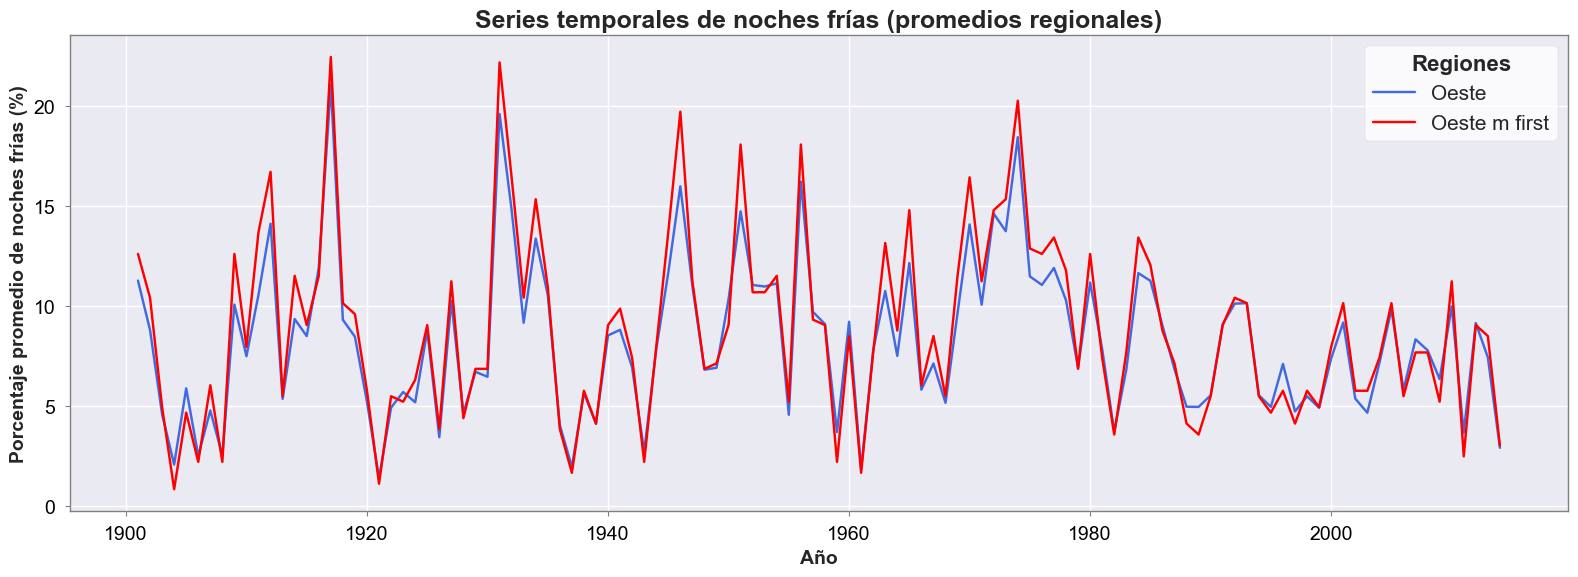

In [412]:
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O,color='royalblue',label='Oeste')
ax.plot(años,perm,color='r',label='Oeste m first')


ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

---

## Calculamos los Cold Days:

In [413]:
# Primero para el caso del oeste
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tmaxO = tmax.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try: # Como el cálculo es costoso, después de la primera vez, guardo los resultados en un fichero. Por eso lo primero que hago es buscarlo para tratar de leerlo de allí.
    tmax_p10_O = xr.open_dataarray('./outs/tmax_p10_O_si.nc')
    percent_cold_days_O = xr.open_dataarray('./outs/percent_cold_days_O_si.nc')
except: # Si no encuentra el fichero hace el cálculo de cero y lo intenta guardar en un fichero.
    tmax_p10_O, percent_cold_days_O = cold_nights_xclim(tmaxO,['1901','2014'])
    tmax_p10_O.to_netcdf('./outs/tmax_p10_O_si.nc')
    percent_cold_days_O.to_netcdf('./outs/percent_cold_days_O_si.nc')
display(tmax_p10_O)
display(percent_cold_days_O)

<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
[746640 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Maximum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-20 01:52:15] per: percentile_doy(arr=tx, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
[232560 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

def cold_nights_xclim_m(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per,freq='MS')
    percent_cold_nights = num_cold/num_cold.time.dt.days_in_month*100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

Lo mismo para el resto de regiones:

In [414]:
try: 
    tmax_p10_E = xr.open_dataarray('./outs/tmax_p10_E.nc')
    percent_cold_days_E = xr.open_dataarray('./outs/percent_cold_days_E.nc')
    print('Leido de outs')
except:
    tmax_p10_E, percent_cold_days_E = cold_nights_xclim(tmax.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmax_p10_E.to_netcdf('./outs/tmax_p10_E.nc')
    percent_cold_days_E.to_netcdf('./outs/percent_cold_days_E.nc')

Leido de outs


In [415]:
try: 
    tmax_p10_C = xr.open_dataarray('./outs/tmax_p10_C.nc')
    percent_cold_days_C = xr.open_dataarray('./outs/percent_cold_days_C.nc')
    print('Leido de outs')
except:
    tmax_p10_C, percent_cold_days_C = cold_nights_xclim(tmax.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmax_p10_C.to_netcdf('./outs/tmax_p10_C.nc')
    percent_cold_days_C.to_netcdf('./outs/percent_cold_days_C.nc')

Leido de outs


In [416]:
try: 
    tmax_p10_S = xr.open_dataarray('./outs/tmax_p10_S.nc')
    percent_cold_days_S = xr.open_dataarray('./outs/percent_cold_days_S.nc')
    print('Leido de outs')
except:
    tmax_p10_S, percent_cold_days_S = cold_nights_xclim(tmax.sel(lat=slice(38,36),lon=slice(-8, 0)),['1901','2014'])
    tmax_p10_S.to_netcdf('./outs/tmax_p10_S.nc')
    percent_cold_days_S.to_netcdf('./outs/percent_cold_days_S.nc')

Leido de outs


In [417]:
try: 
    tmax_p10_N = xr.open_dataarray('./outs/tmax_p10_N.nc')
    percent_cold_days_N = xr.open_dataarray('./outs/percent_cold_days_N.nc')
    print('Leido de outs')
except:
    tmax_p10_N, percent_cold_days_N = cold_nights_xclim(tmax.sel(lat=slice(43.8,42.5),lon=slice(-6,0)),['1901','2014'])
    tmax_p10_N.to_netcdf('./outs/tmax_p10_N.nc')
    percent_cold_days_N.to_netcdf('./outs/percent_cold_days_N.nc')


Leido de outs


Pintamos el promedio temporal en el mapa de España:

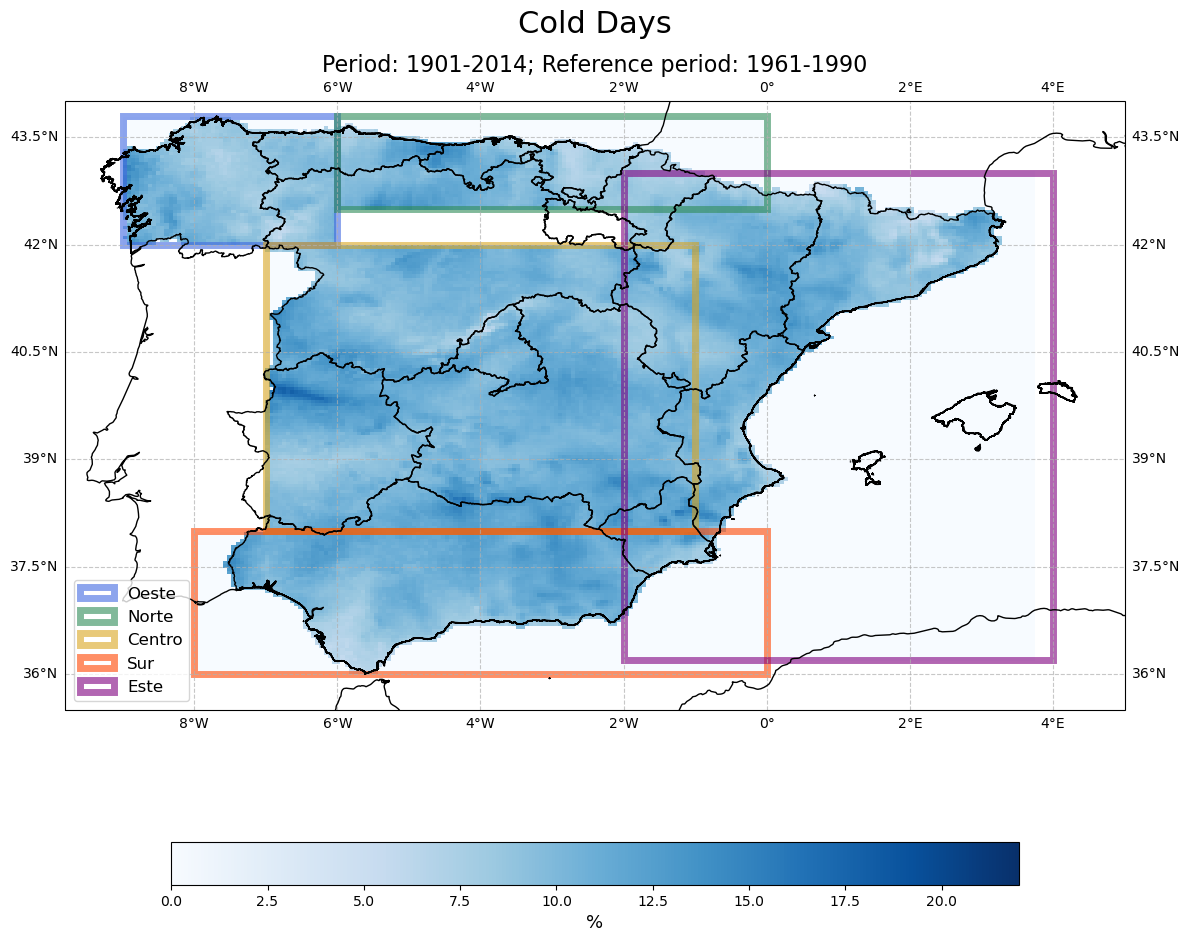

In [418]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = './mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Days',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# A partir de aquí vamos a pintar los valores promedio de días fríos en el periodo empleado  
cmap = 'Blues'

var =  percent_cold_days_O.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
# print(var.max().squeeze())

var =  percent_cold_days_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
# print(var.max().squeeze())

var =  percent_cold_days_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
# print(var.max().squeeze())


var =  percent_cold_days_S.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
# print(var.max().squeeze())


var =  percent_cold_days_N.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
# print(var.max().squeeze())

# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)


# Ahora pintamos las regiones (solo cuadrados sin relleno) 
pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste',fill=False,lw=5)
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte',fill=False,lw=5)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro',fill=False,lw=5)
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur',fill=False,lw=5)
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este',fill=False,lw=5)

ax.legend(prop={'size':12})
plt.tight_layout()

In [419]:
#fig.savefig('cold_days2.png',dpi=600,facecolor='w')

Dividimos en dos periodos y calculamos las diferencias:

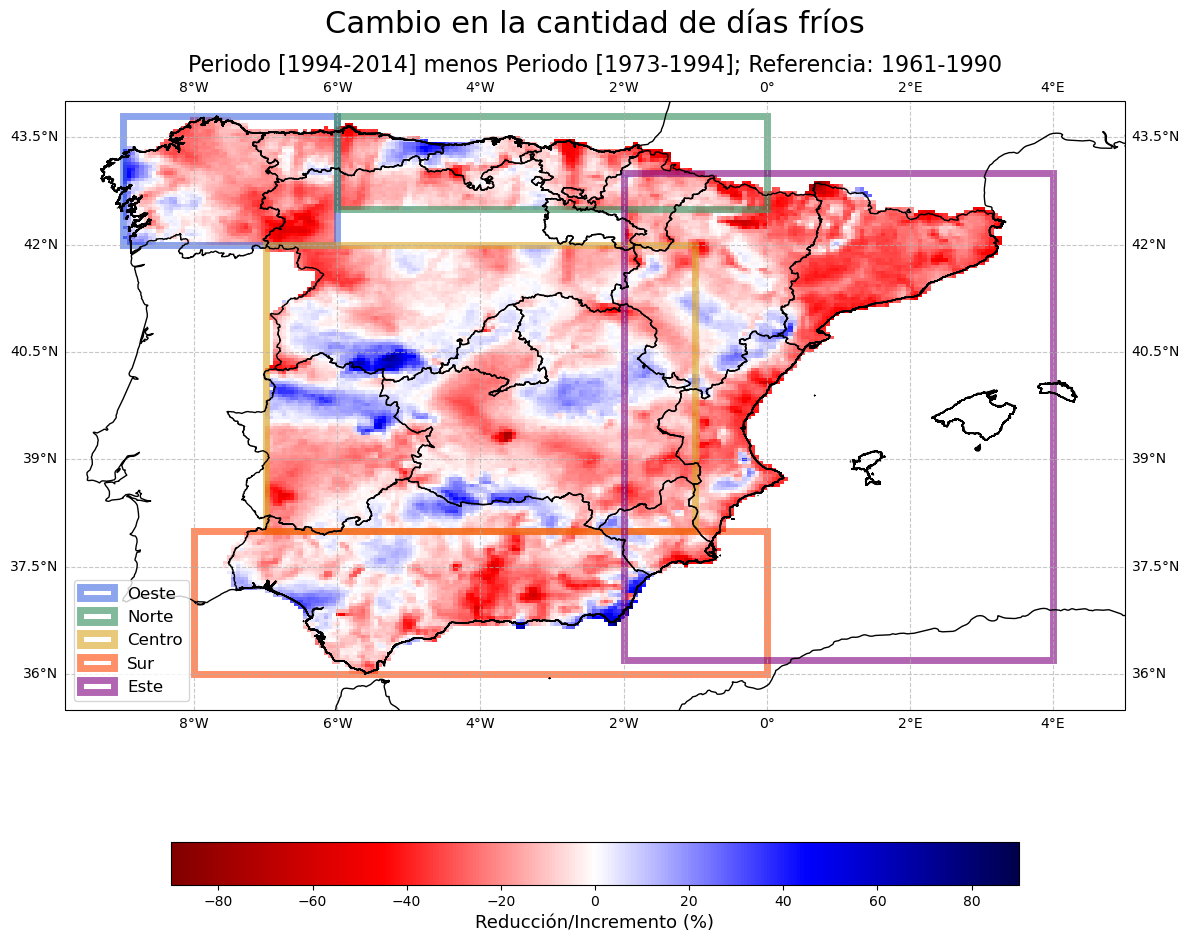

In [420]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = './mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cambio en la cantidad de días fríos',size=22)
plt.title('Periodo [1994-2014] menos Periodo [1973-1994]; Referencia: 1961-1990',size=16)


# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90

var = (percent_cold_days_O.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_O.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_O.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
# print(var.max().squeeze())

var = (percent_cold_days_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
# print(var.max().squeeze())

var = (percent_cold_days_C.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_C.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_C.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) 
# print(var.max().squeeze())


var = (percent_cold_days_S.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_S.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_S.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
# print(var.max().squeeze())


var = (percent_cold_days_N.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_N.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_N.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
# print(var.max().squeeze())

# Barra de color
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)


# Ahora pintamos las regiones (solo cuadrados sin relleno) 
pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste',fill=False,lw=5)
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte',fill=False,lw=5)
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro',fill=False,lw=5)
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur',fill=False,lw=5)
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este',fill=False,lw=5)


ax.legend(prop={'size':12})
plt.tight_layout()

In [421]:
#fig.savefig('cambios_days.png',dpi=600,facecolor='w')

Ahora vamos a corregir lasa series, promediarlas espacialmente y dibujarlas en función del tiempo:

In [422]:
corr_E_d = correct_series(percent_cold_days_E)

In [423]:
corr_N_d = correct_series(percent_cold_days_N)

In [424]:
corr_S_d = correct_series(percent_cold_days_S)

In [425]:
corr_O_d = correct_series(percent_cold_days_O)

In [426]:
corr_C_d = correct_series(percent_cold_days_C)

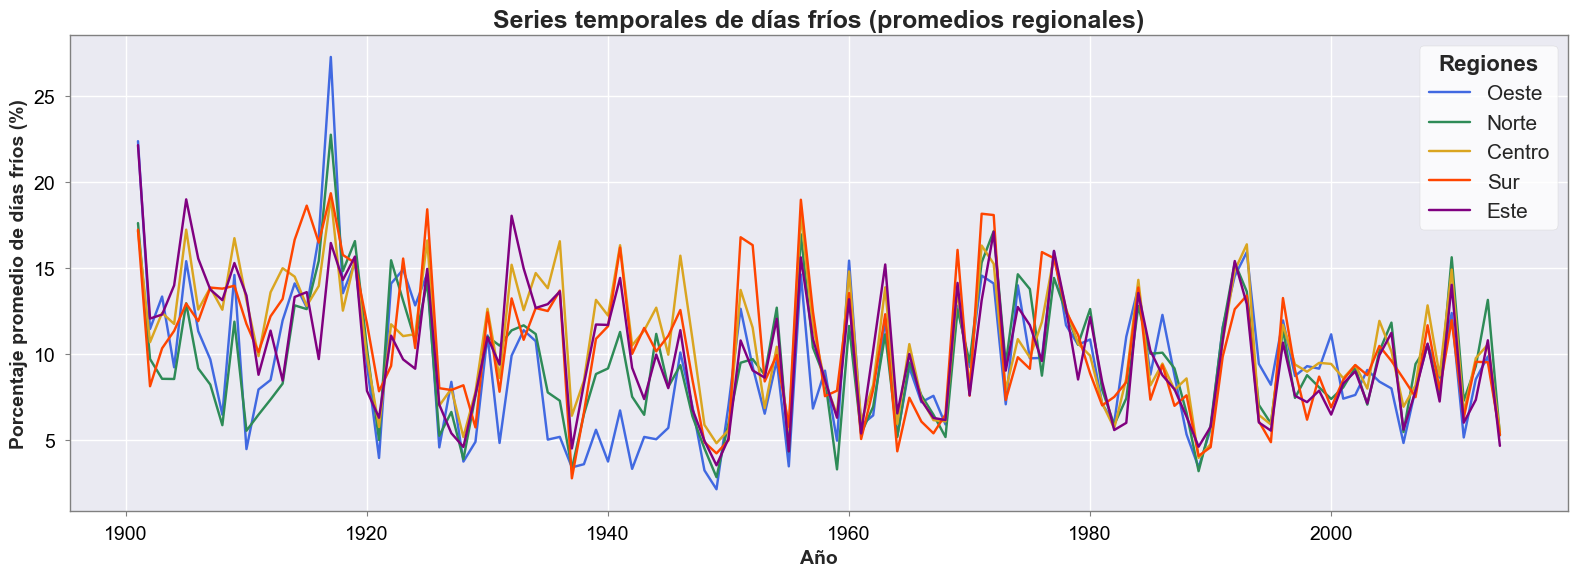

In [427]:
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O_d,color='royalblue',label='Oeste')
ax.plot(años,corr_N_d,color='seagreen',label='Norte')
ax.plot(años,corr_C_d,color='goldenrod',label='Centro')
ax.plot(años,corr_S_d,color='orangered',label='Sur')
ax.plot(años,corr_E_d,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')
plt.tight_layout()

---

## Series mensuales:

Vamos a intentar hacer las series por meses en vez de años:

Vamos a hacerlo para el oeste:

In [428]:
tmax_O = tmax.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
tmax2_O = tmax_O.rename({'Time': 'time'})
tmax2_O.attrs['units'] = 'degC'
try: 
    num_cold_days_O_m = xr.open_dataarray('./outs/tmax_p10_O_m_full.nc')
except: 
    num_cold_days_O_m = tx10p(tmax2_O.sel(time=slice('1901','2014')),tmax_p10_O,freq='MS') #.mean(dim=['lon','lat'])
    num_cold_days_O_m.to_netcdf('./outs/tmax_p10_O_m_full.nc')

In [429]:
tmin_O = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
tmin_O = tmin_O.rename({'Time': 'time'})
tmin_O.attrs['units'] = 'degC'
try: 
    num_cold_nights_O_m = xr.open_dataarray('./outs/percent_cold_nights_O_m_FULL.nc')
except: 
    num_cold_nights_O_m = tx10p(tmin_O.sel(time=slice('1901','2014')),tmin_p10_O,freq='MS') #.mean(dim=['lon','lat'])
    num_cold_nights_O_m.to_netcdf('./outs/percent_cold_nights_O_m_FULL.nc')

In [430]:
# Hay que dividir cada mes entre su número de días y multiplicar por 100 para obtener porcentajes
percent_cold_nights_O_m = num_cold_nights_O_m/num_cold_nights_O_m.time.dt.days_in_month*100
percent_cold_days_O_m = num_cold_days_O_m/num_cold_days_O_m.time.dt.days_in_month*100


In [431]:
percent_cold_days_O_m

<xarray.DataArray (time: 1368, lat: 40, lon: 51)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  9.67741935,   9.67741935,  12.90322581, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,  12.90322581,  19.35483871, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,   9.67741935,  19.35483871, ...,   6.4516129 ,
           6.4516129 ,   3.22580645]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [  0.        ,   3.33333333,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   3.33333333, ...,   6.66666667,
           3.33333333,   3.33333333]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  3.22580645,   3.22580645,   3.22580645, ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   3.22580645],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 10
  * time         (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01

In [432]:
percent_cold_days_O_m

<xarray.DataArray (time: 1368, lat: 40, lon: 51)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  9.67741935,   9.67741935,  12.90322581, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,  12.90322581,  19.35483871, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,   9.67741935,  19.35483871, ...,   6.4516129 ,
           6.4516129 ,   3.22580645]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [  0.        ,   3.33333333,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   3.33333333, ...,   6.66666667,
           3.33333333,   3.33333333]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  3.22580645,   3.22580645,   3.22580645, ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   3.22580645],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 10
  * time         (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01

Hay que corregir la serie antes de promediar espacialmente:

In [433]:
corr_O_monthly = correct_series(percent_cold_days_O_m,freq='MS')
corr_O_monthly

<xarray.DataArray (time: 1368)>
array([11.16762101, 84.18845487, 33.4850802 , ...,  0.7486574 ,
        4.88055862,  6.58320589])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01

In [434]:
corrN_O_monthly = correct_series(percent_cold_nights_O_m,freq='MS')

Representamos la serie temporal del promedio espacial para cada unos de los índices:

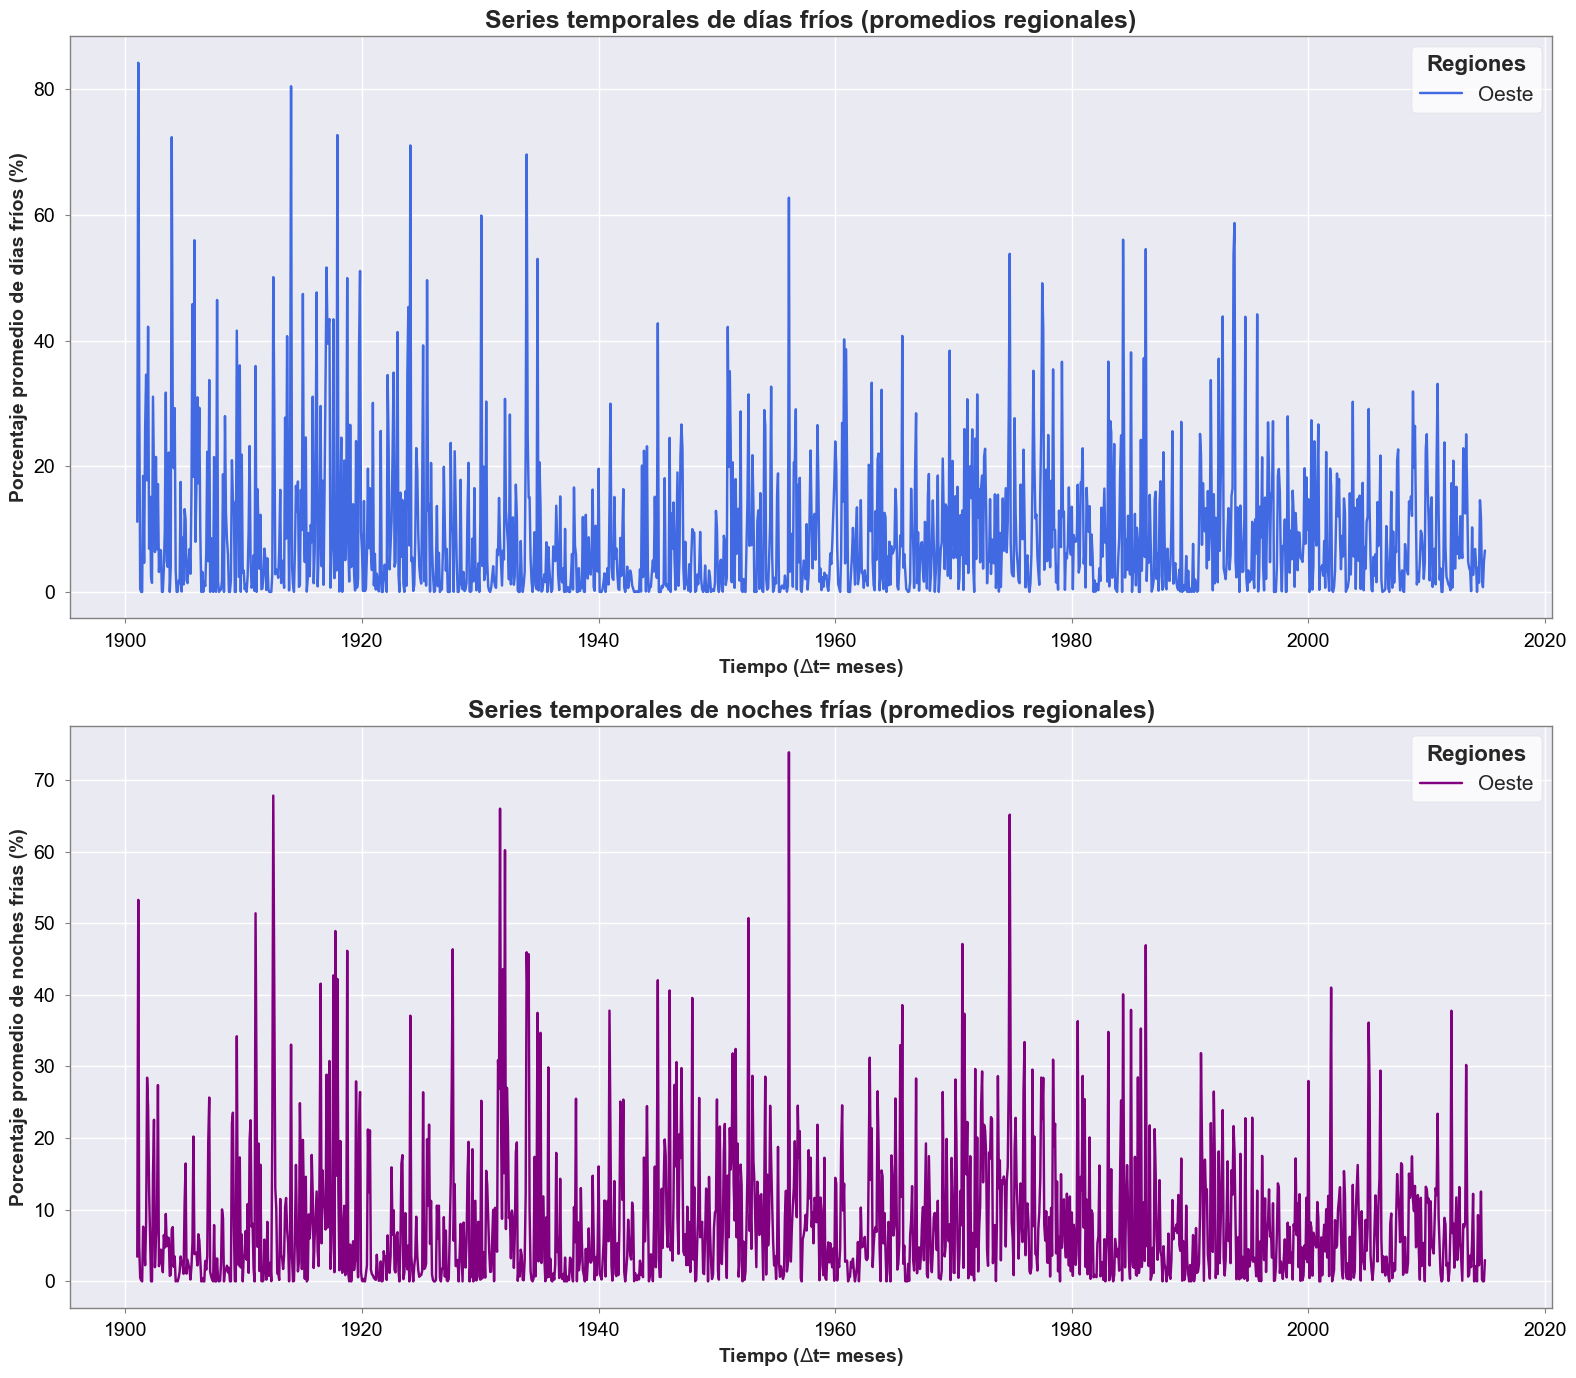

In [435]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

var = corr_O_monthly # Días fríos
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Tiempo ($\Delta$t= meses)')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_O_monthly # Noches frías
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Tiempo ($\Delta$t= meses)')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

Voy a calcular anomalías mensuales:

In [436]:
anom_O = (corr_O_monthly.groupby('time.month')-corr_O_monthly.groupby('time.month').mean('time'))#/(corr_O_monthly.groupby('time.month').std('time'))

In [437]:
# Ahora la anomalía estandarizada
anom_O_std = anom_O.groupby('time.month')/corr_O_monthly.groupby('time.month').std('time')
anom_O_std

<xarray.DataArray (time: 1368)>
array([-0.11401401,  4.79974387,  2.51817406, ..., -0.63320051,
       -0.43841266, -0.34293353])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [438]:
# Ahora para las noches frías
anom_ON_std = (corrN_O_monthly.groupby('time.month')-corrN_O_monthly.groupby('time.month').mean('time')).groupby('time.month')/corrN_O_monthly.groupby('time.month').std('time')
anom_ON_std

<xarray.DataArray (time: 1368)>
array([-0.63690475,  3.09378631, -0.13021036, ..., -0.86298774,
       -0.90487515, -0.51253439])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Pintamos la serie de anomalías:

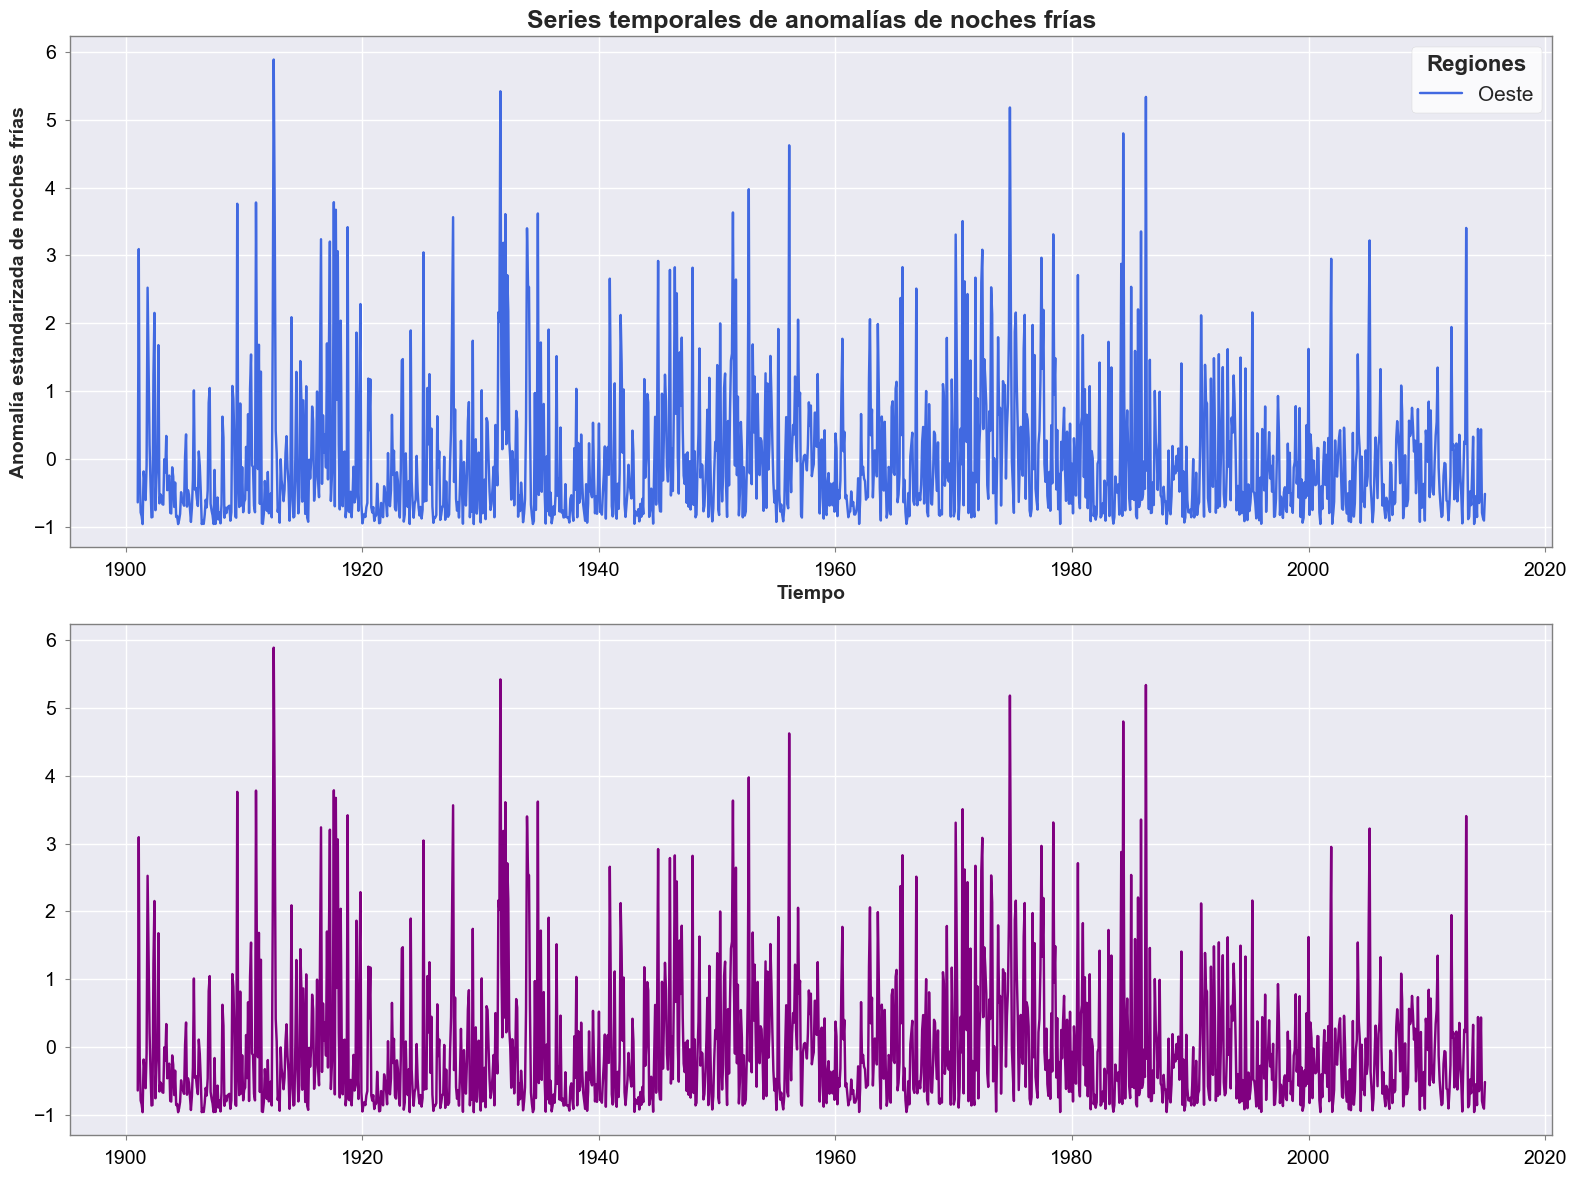

In [439]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,12))

var = anom_ON_std # Días fríos
ax.plot(var.time,var,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Tiempo')
ax.set_ylabel(u'Anomalía estandarizada de días fríos')
ax.set_title('Series temporales de anomalías de días fríos')

var = anom_ON_std # Noches frías
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax.set_xlabel(u'Tiempo')
ax.set_ylabel(u'Anomalía estandarizada de noches frías')
ax.set_title('Series temporales de anomalías de noches frías')
plt.tight_layout()

---

## Periodograma y filtrado (de la serie de anomalías mensuales)

In [440]:
# Funciones definidas en la libreta de clase
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

La varianza de la serie original, es  <xarray.DataArray ()>
array(1.)
La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es  1.0000000000000067 0.9999999999999998


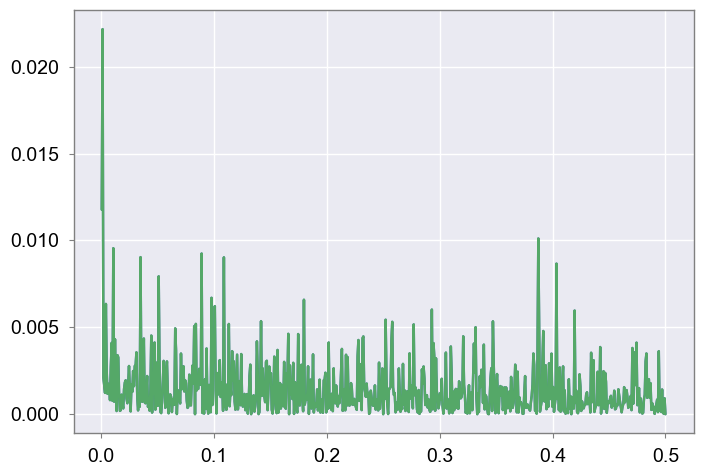

In [441]:
# Vamos a dibujar el espectro de la serie temporal
x = anom_O_std
fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
plt.plot(fa,Ga)
plt.plot(ff,Gf)
print('La varianza de la serie original, es ',np.var(x))
print('La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es ',np.sum(Ga),np.sum(Gf))

Vamos a pintar los espectros de ambas series y ver si tienen picos significativos haciendo contraste de hipótesis con AR1 y tomando $\alpha=0.1 $

>>Serie de días fríos:
La varianza de la serie es  0.9999999999999972
La integral del espectro es  0.9999999999999999
>>Serie de noches frías:
La varianza de la serie es  1.0000000000000002
La integral del espectro es  0.9999999999999998


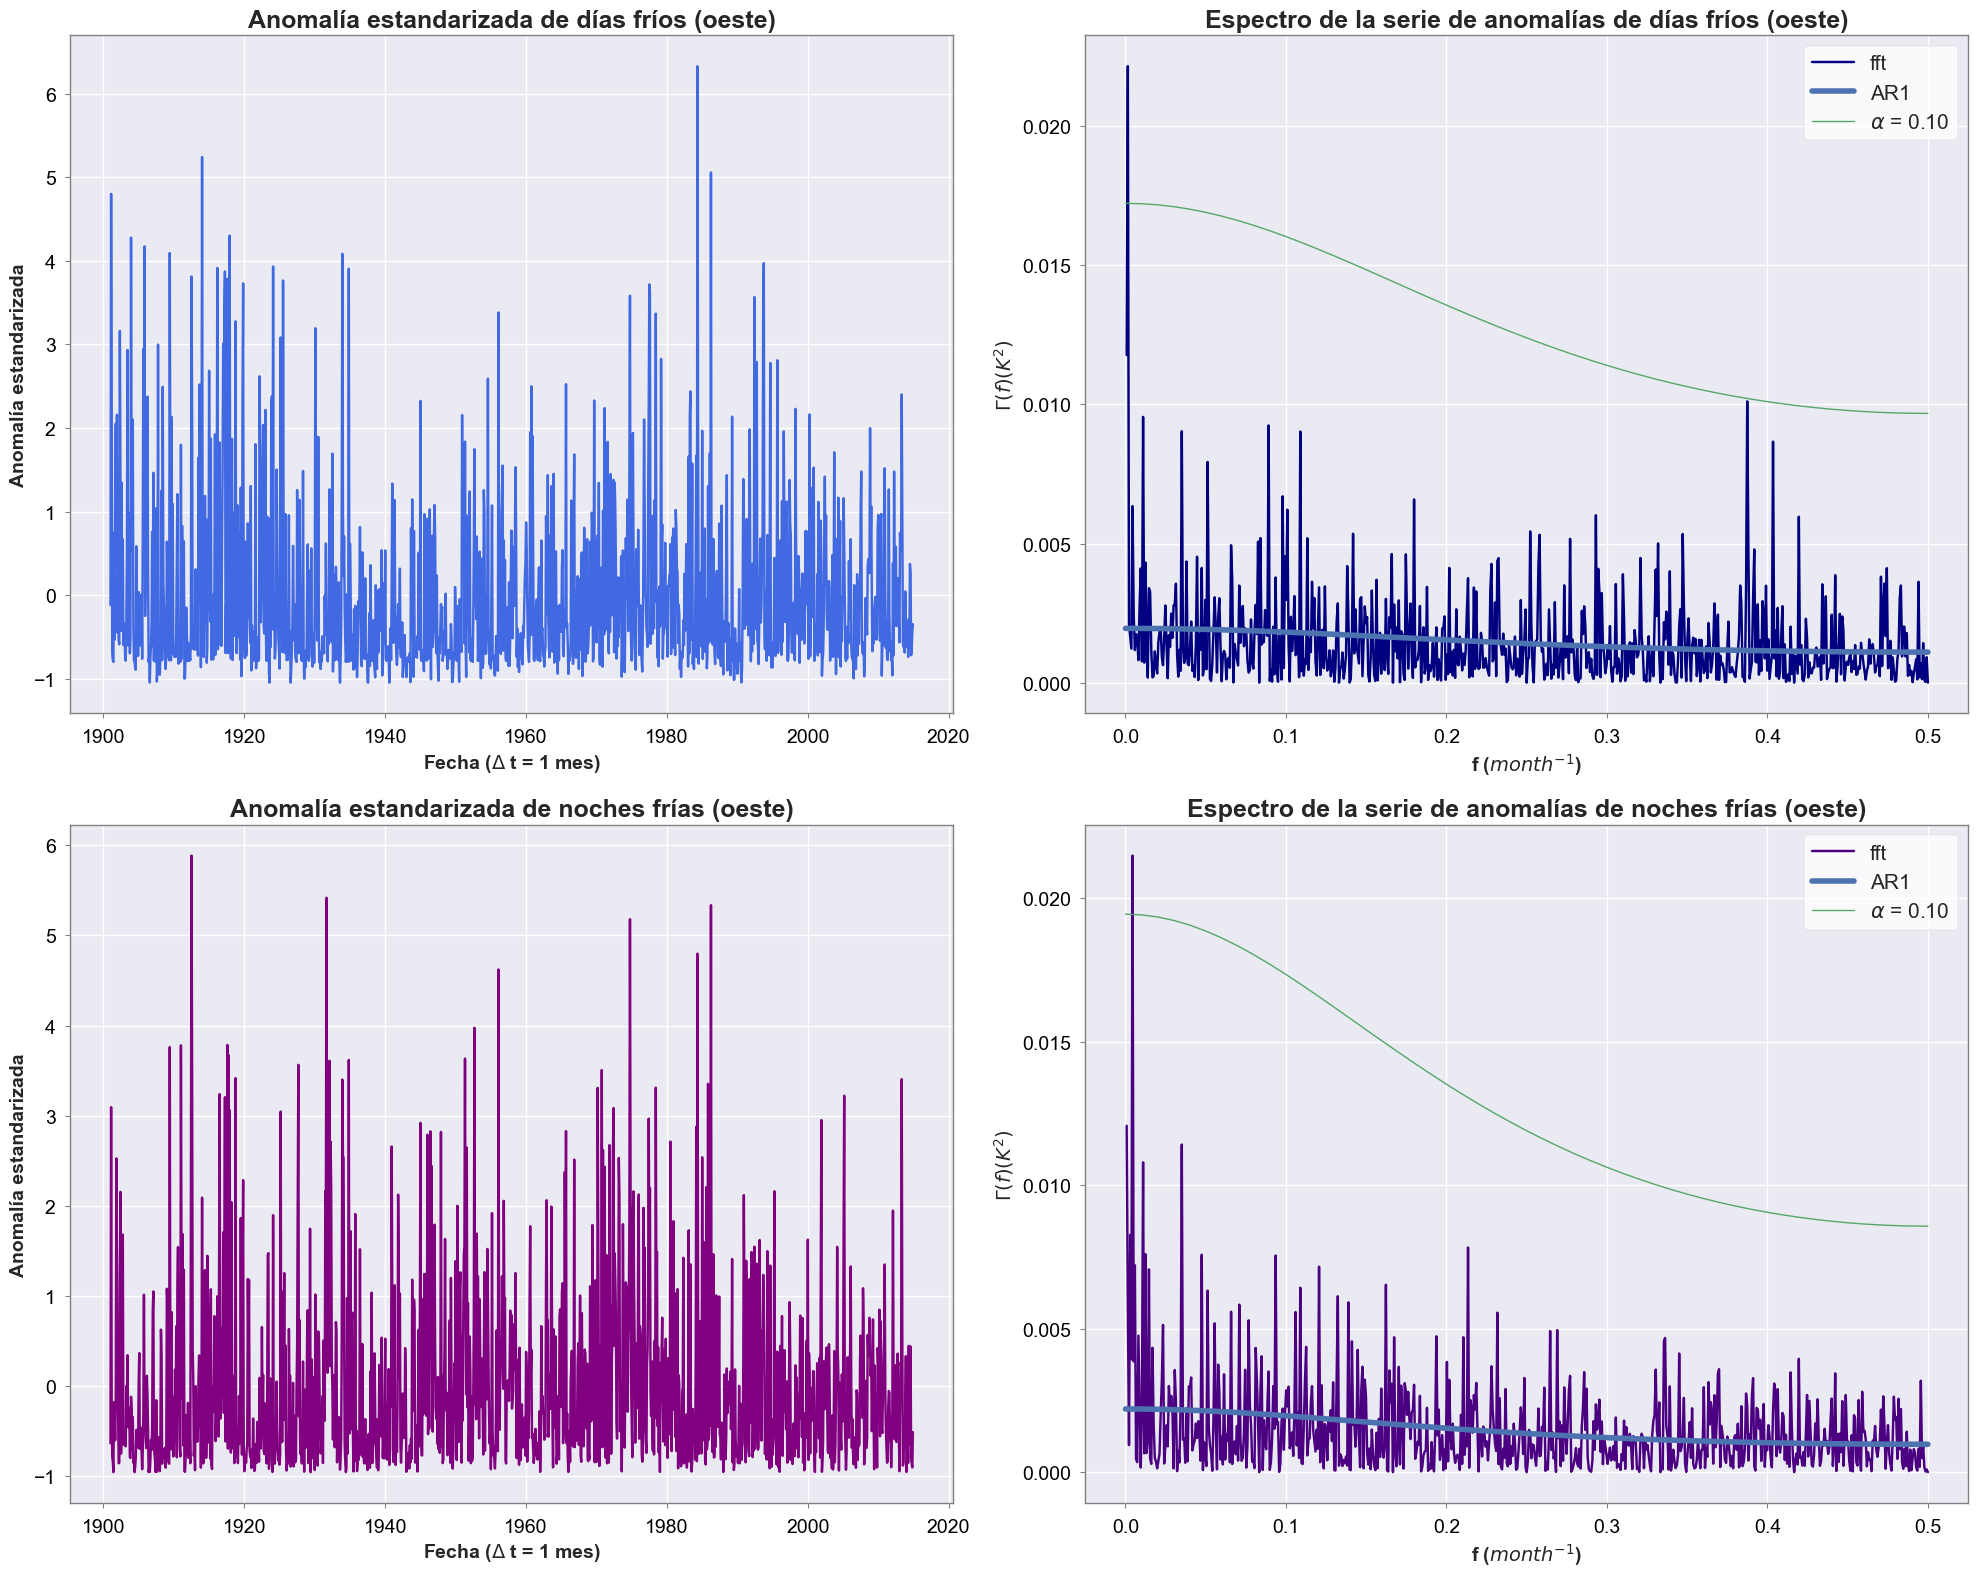

In [444]:
fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))

x = anom_O_std
ax[0].plot(x.time,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

ff_d = ff # Lo guardo
Gf_d = Gf # Lo guardo

print('>>Serie de días fríos:')
print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x = anom_ON_std
axd[0].plot(x.time,x,color='purple')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
axd[1].plot(ff,Gf,label='fft',color='indigo')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('>>Serie de noches frías:')
print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()


#ax[1].set_xlim(0.385,0.39)
#axd[1].set_xlim(0,0.02)


plt.tight_layout()

In [445]:
# Pico a bajas frecuencias
cut = 1/ff_d[np.argmax(Gf_d[ff_d<0.01])]/12
print('Periodicidad de %.1f años.'%(cut))

Periodicidad de 57.0 años.


### Filtrado:

Vamos a intentar filtrar la de días fríos (ya que tiene dos picos significativos):

Filtro Butterworth pasa baja:

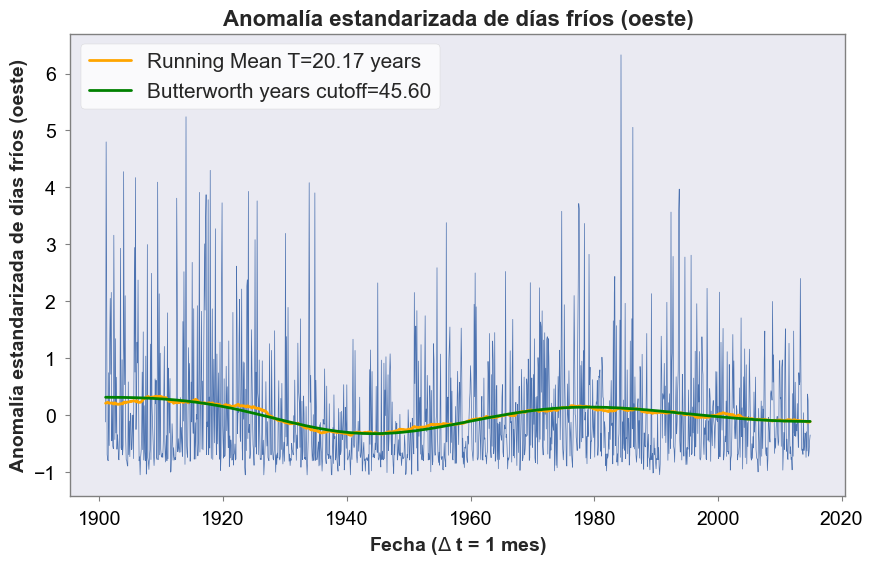

In [447]:
series_style()
fig,ax = plt.subplots(1,1,figsize=(10,6))


cut = cut-cut/5 # Para quitar algo más alrededor de esa frecuencia
# La señal inicial
x = np.squeeze(np.array(anom_O_std))

t = np.squeeze(np.array(anom_O_std.time))
N = x.size
ax.plot(t,x,linewidth=0.5) # Represento la serie


#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte (en meses) (15 años):
nyc = cut
Tc = nyc *12
fc = 1 / Tc

#Media móvil: necesito una ventana de aprox. Tc/0.443
Window = int(0.443/fc)

#Filtro la señal ampliada y luego me quedo con el trozo central
ytot = runningMean(xtot,Window)
yRunningMean = ytot[N:2*N]


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,fc*2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter = ytot[N:2*N]


ax.grid()
ax.set_title(u'Anomalía estandarizada de días fríos (oeste)',fontsize=16,weight='bold')
ax.set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax.set_ylabel(u'Anomalía estandarizada de días fríos (oeste)')
ax.plot(t,yRunningMean,linewidth= 2,color='orange',label='Running Mean T=%.2f years'%(Window/12)) #Media móvil
ax.plot(t,yButter,linewidth= 2,color='green',label='Butterworth years cutoff=%.2f'%(nyc)) # Filtro Butter
ax.legend()

In [448]:
#fig.savefig('filtro_baja.png',dpi=300,facecolor='w')

Y ahora busquemos la frecuencia alta:

In [449]:
# Pico a alta frecuencia
cuth = 1/ff_d[(0.387<ff_d)&(ff_d<0.388)]
#Gf_d[(0.387<ff_d)&(ff_d<0.388)]
print('Periodicidad de %.2f meses.'%(cuth))

Periodicidad de 2.58 meses.


Filtro Butterworth pasa banda:

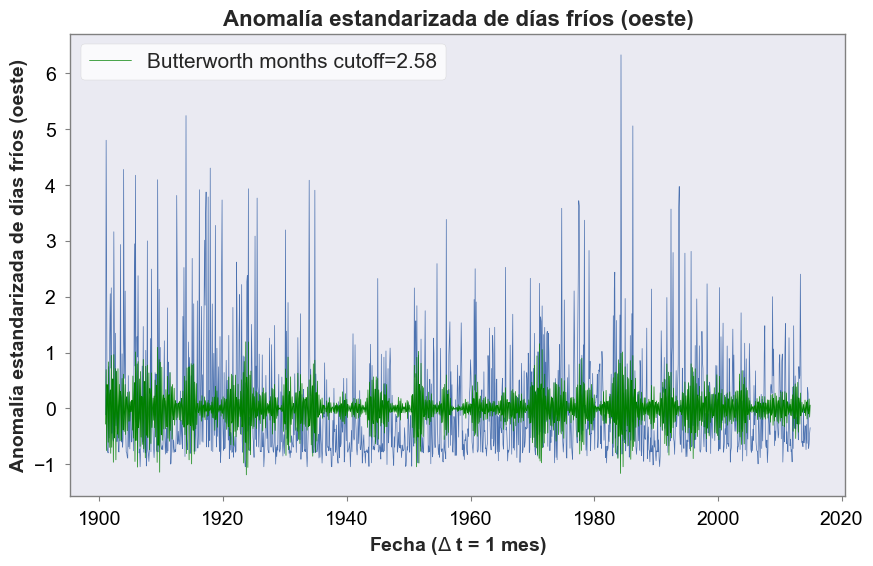

In [450]:
series_style()
fig,ax = plt.subplots(1,1,figsize=(10,6))

# La señal inicial
x = np.squeeze(np.array(anom_O_std))

t = np.squeeze(np.array(anom_O_std.time))
N = x.size
ax.plot(t,x,linewidth=0.5) # Represento la serie


#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte (en meses) (15 años):
# nyc = cut
Tc = float(cuth)
fc1 = 1 / Tc


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist (por eso se multiplica por 2)
n = 4
fc = fc1*2
b,a = signal.butter(n,[fc-fc/10,fc+fc/10],output='ba',btype='bandpass')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter2 = ytot[N:2*N]


ax.grid()
ax.set_title(u'Anomalía estandarizada de días fríos (oeste)',fontsize=16,weight='bold')
ax.set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax.set_ylabel(u'Anomalía estandarizada de días fríos (oeste)')
ax.plot(t,yButter2,linewidth= 0.5,color='green',label='Butterworth months cutoff=%.2f'%(cuth)) # Filtro
# ax.set_xlim([1870,2020])
ax.legend()

In [451]:
#fig.savefig('filtro_alta.png',dpi=300,facecolor='w')

Vamos a ver que efectos tiene quitar las frecuencias del filtro:

In [452]:
# Vamos a ver como queda quitando esas frecuencias
filt_O = anom_O_std-yButter-yButter2

In [453]:
# Función para poner títulos a cada fila de un subplot
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='bold',fontsize=24)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

Representamos: primero la serie y su espectro, luego las frecuencias filtradas de los picos significativos y finalmente la serie y su espectro una vez sustraidos los resultados del filtrado:

La varianza de la serie es  0.9999999999999972
La integral del espectro es  0.9999999999999999
La varianza de la serie es  0.8058321427117562
La integral del espectro es  0.8058327492121098
La varianza de la serie es  0.16021952544496956
La integral del espectro es  0.16022013194532428


C:\Users\digar7\AppData\Local\Temp/ipykernel_51644/4112104153.py:93: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.tight_layout()


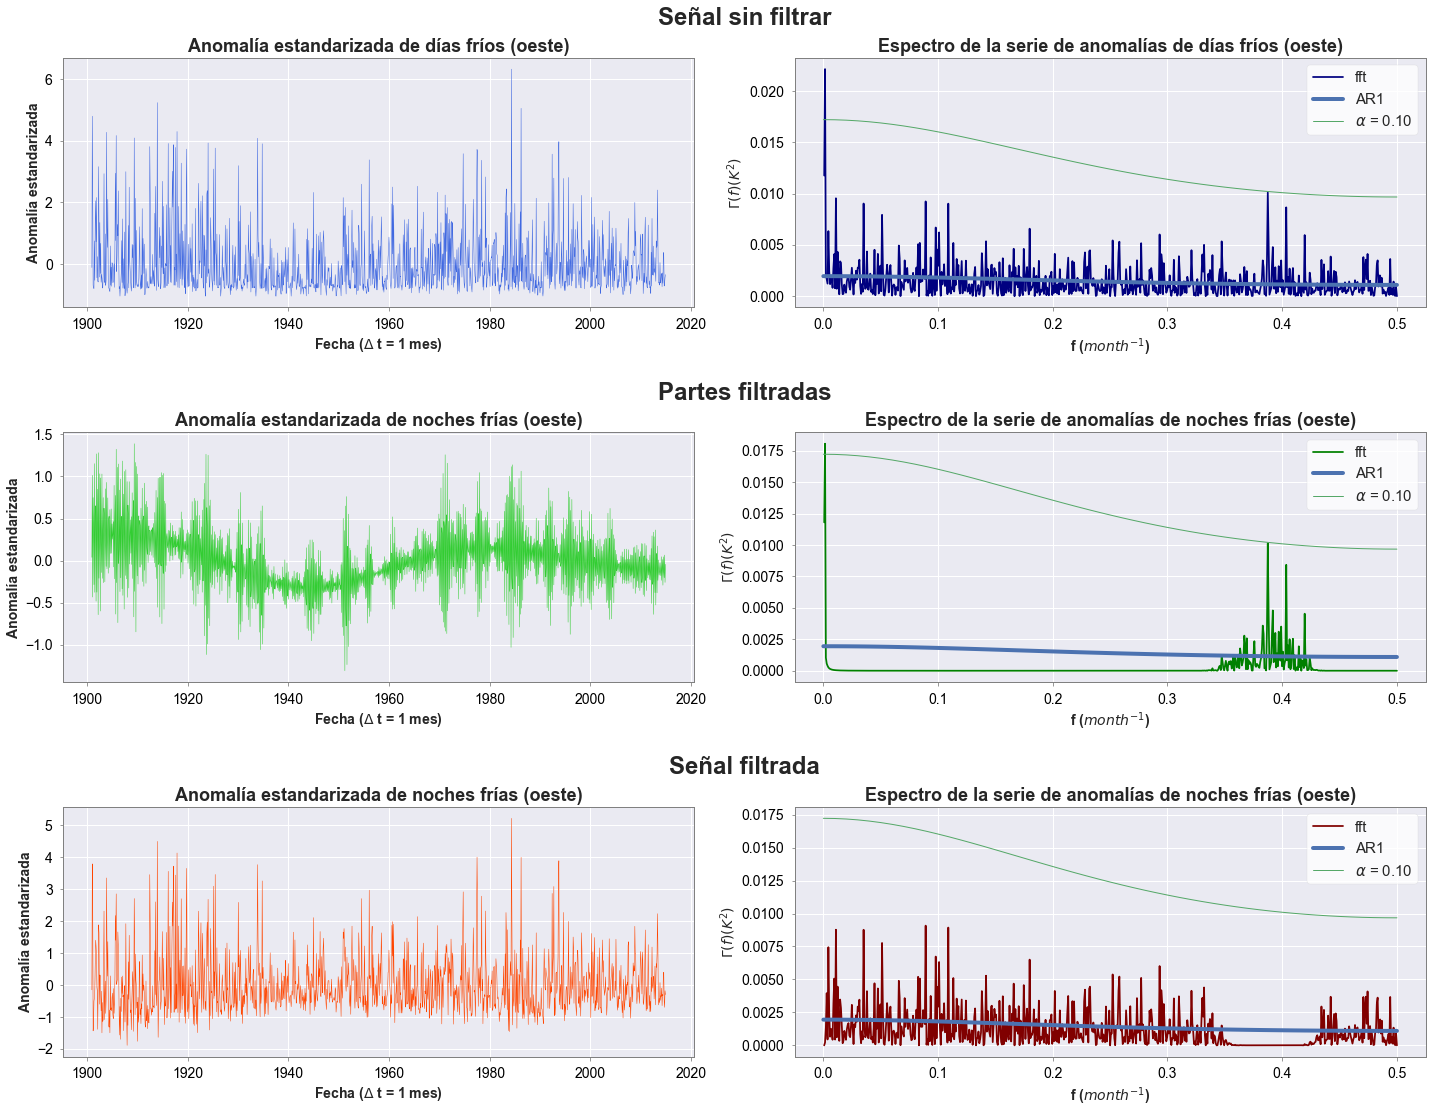

In [457]:
%matplotlib inline
fig,(ax,ax3,axd)=plt.subplots(3,2,figsize=(20,16))


# Fila 1: serie original y su espectro
x = anom_O_std
años = x.time
ax[0].plot(x.time,x,color='royalblue',linewidth=0.5)
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')

ff,Gf = espectroFFT(x,1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

ff_d = ff # Lo guardo
Gf_d = Gf # Lo guardo


print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


# Fila 3: La señal quitando los picos significativos
x = filt_O
axd[0].plot(x.time,x,color='orangered',linewidth=0.5)
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


ff,Gf = espectroFFT(x,1)
axd[1].plot(ff,Gf,label='fft',color='maroon')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))
axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))

axd[1].legend()



# Fila 2: solo lo que hemos filtrado
x = yButter+yButter2
ax3[0].plot(años,x,color='limegreen',linewidth=0.5)
ax3[0].set_ylabel(u'Anomalía estandarizada')
ax3[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax3[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


ff,Gf = espectroFFT(x,1)
ax3[1].plot(ff,Gf,label='fft',color='g')
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))
ax3[1].plot(f,G/x.size,linewidth=4,label='AR1')
ax3[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
ax3[1].legend()

plt.tight_layout()
grid = plt.GridSpec(3,3)
create_subtitle(fig, grid[0, ::], 'Señal sin filtrar')
create_subtitle(fig, grid[1, ::], 'Partes filtradas')
create_subtitle(fig, grid[2, ::], 'Señal filtrada')
fig.tight_layout()
plt.subplots_adjust(hspace=0.5,top=0.92)

In [458]:
#fig.savefig('filtrado_oeste.png',dpi=400,facecolor='w')

---

## Series por estaciones:

Vamos a intentar hacerlo por estaciones a ver si obtenemos más información:

In [459]:
# Algunas funciones de https://docs.xarray.dev/en/v0.9.2/examples/monthly-means.html
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [460]:
def resample_month_to_season(ds):
    ''' Función para pasar de una serie mensual a una serie estacional'''
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),
        coords=[ds.time],name='month_length')

    # Primero lo paso de vuelta a número de días
    result = ((ds * month_length/100).resample(time='QS-DEC').sum() / 
            month_length.resample(time='QS-DEC').sum())*100 # Hay que dividir entre los días de cada estación 
    return result

# Calculo las series estacionales para el oeste
corrN_O_seasons = resample_month_to_season(corrN_O_monthly)
corr_O_seasons = resample_month_to_season(corr_O_monthly)

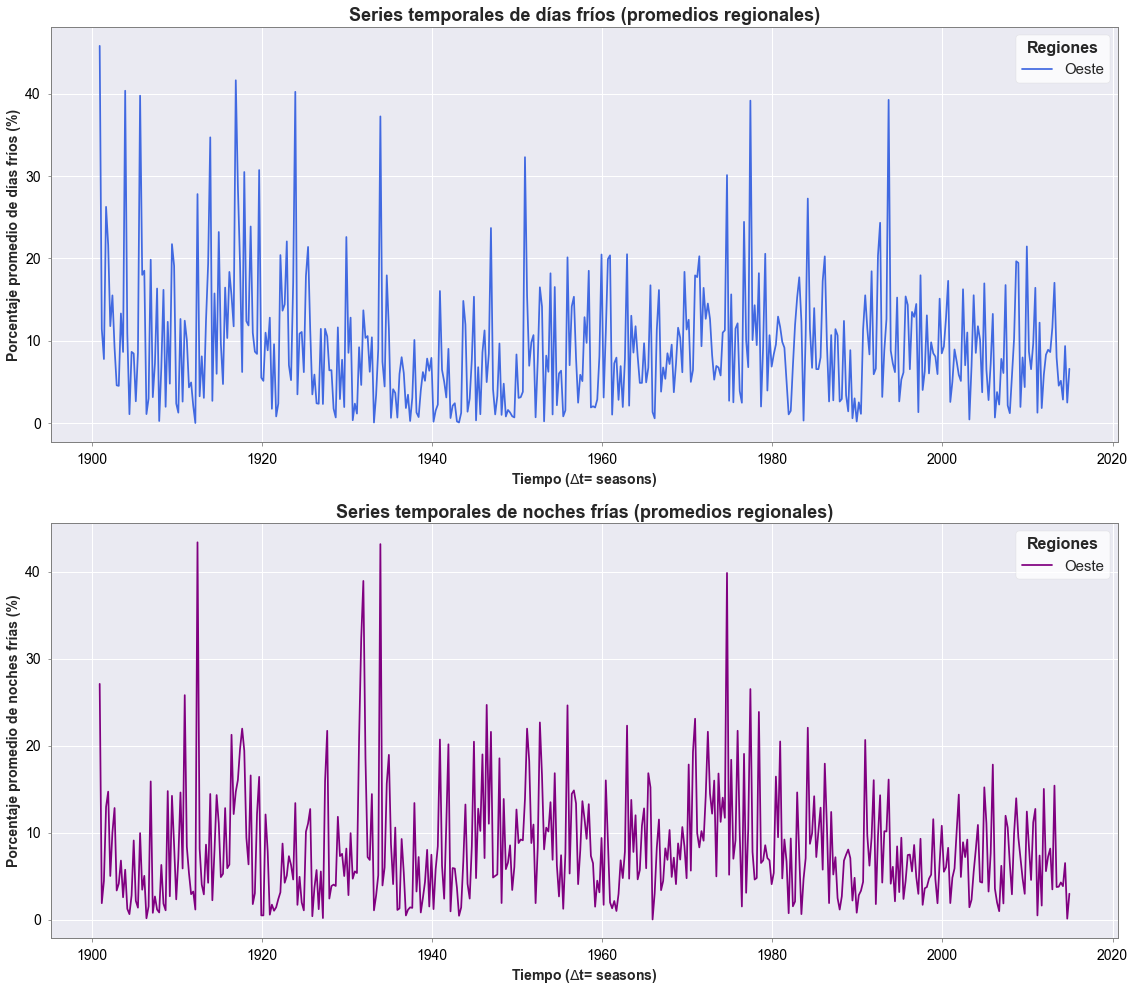

In [461]:
# Dibujo las series estacionales 
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

var = corr_O_seasons # Días fríos
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_O_seasons # Noches frías
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

Ahora seleccionamos una cierta estación de cada año:

In [462]:
# Seleccionaré las primaveras, representadas por su primer mes: marzo
corrN_O_spring = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==3))
corr_O_spring = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==3))

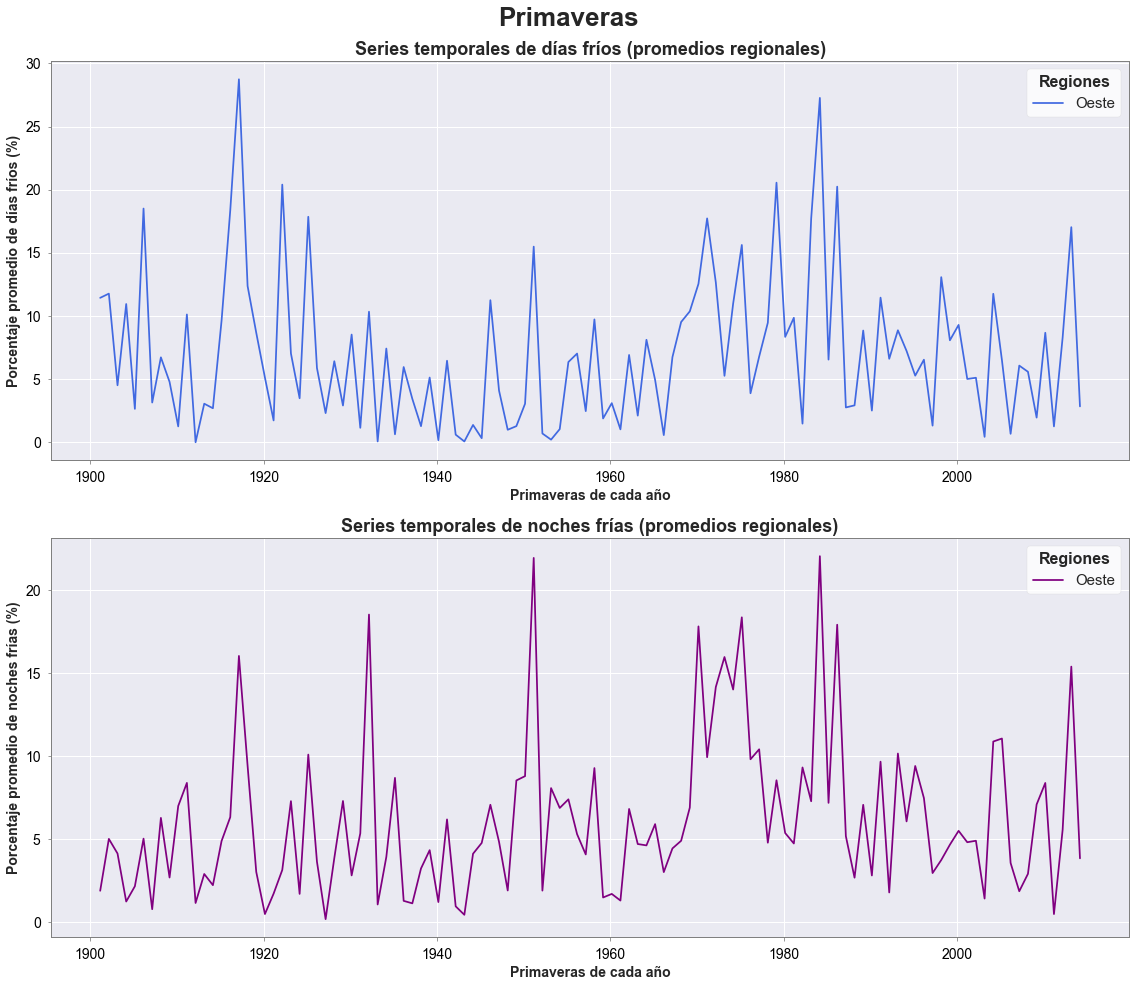

In [463]:
# Dibujo la serie anual solo con las primaveras 
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

fig.suptitle('Primaveras',size=26,weight='bold')
var = corr_O_spring
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Primaveras de cada año')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_O_spring
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Primaveras de cada año')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

Ahora vamos a hacer el análisis de espectro para las series anuales por estaciones:

In [464]:
# Como voy a tener que hacer los plots para 4 estaciones hago una función 
def armonics_plot(days,nights,season):
    ''' Función para hacer el análisis del espectro de la serie estacional'''
    fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))


    # Fila de arriba
    var = days
    x = (var-var.mean())/var.std() # Calculo la anomalía
    ax[0].plot(x.time,x,color='royalblue')
    ax[0].set_ylabel(u'Anomalía estandarizada')
    ax[0].set_xlabel(r'%s de cada año'%(season))
    ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    ax[1].plot(ff,Gf,label='fft',color='navy')
    ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    ax[1].set_xlabel(r'f ($año^{-1}$)')
    ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    ax[1].legend()



    # Fila de abajo
    var = nights
    x = (var-var.mean())/var.std() # Calculo la anomalía
    axd[0].plot(x.time,x,color='purple')
    axd[0].set_ylabel(u'Anomalía estandarizada')
    axd[0].set_xlabel(r'%s de cada año'%(season))
    axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


    ff,Gf = espectroFFT(x,1)
    axd[1].plot(ff,Gf,label='fft',color='indigo')
    axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    axd[1].set_xlabel(r'f ($año^{-1}$)')
    axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    axd[1].legend()

    fig.suptitle(r'%s'%(season),size=26,weight='bold')


    plt.tight_layout()
    return fig, (ax,axd)

La varianza de la serie es  0.9999999999999999
La integral del espectro es  1.00389507889661
La varianza de la serie es  1.0
La integral del espectro es  1.0012143615931435


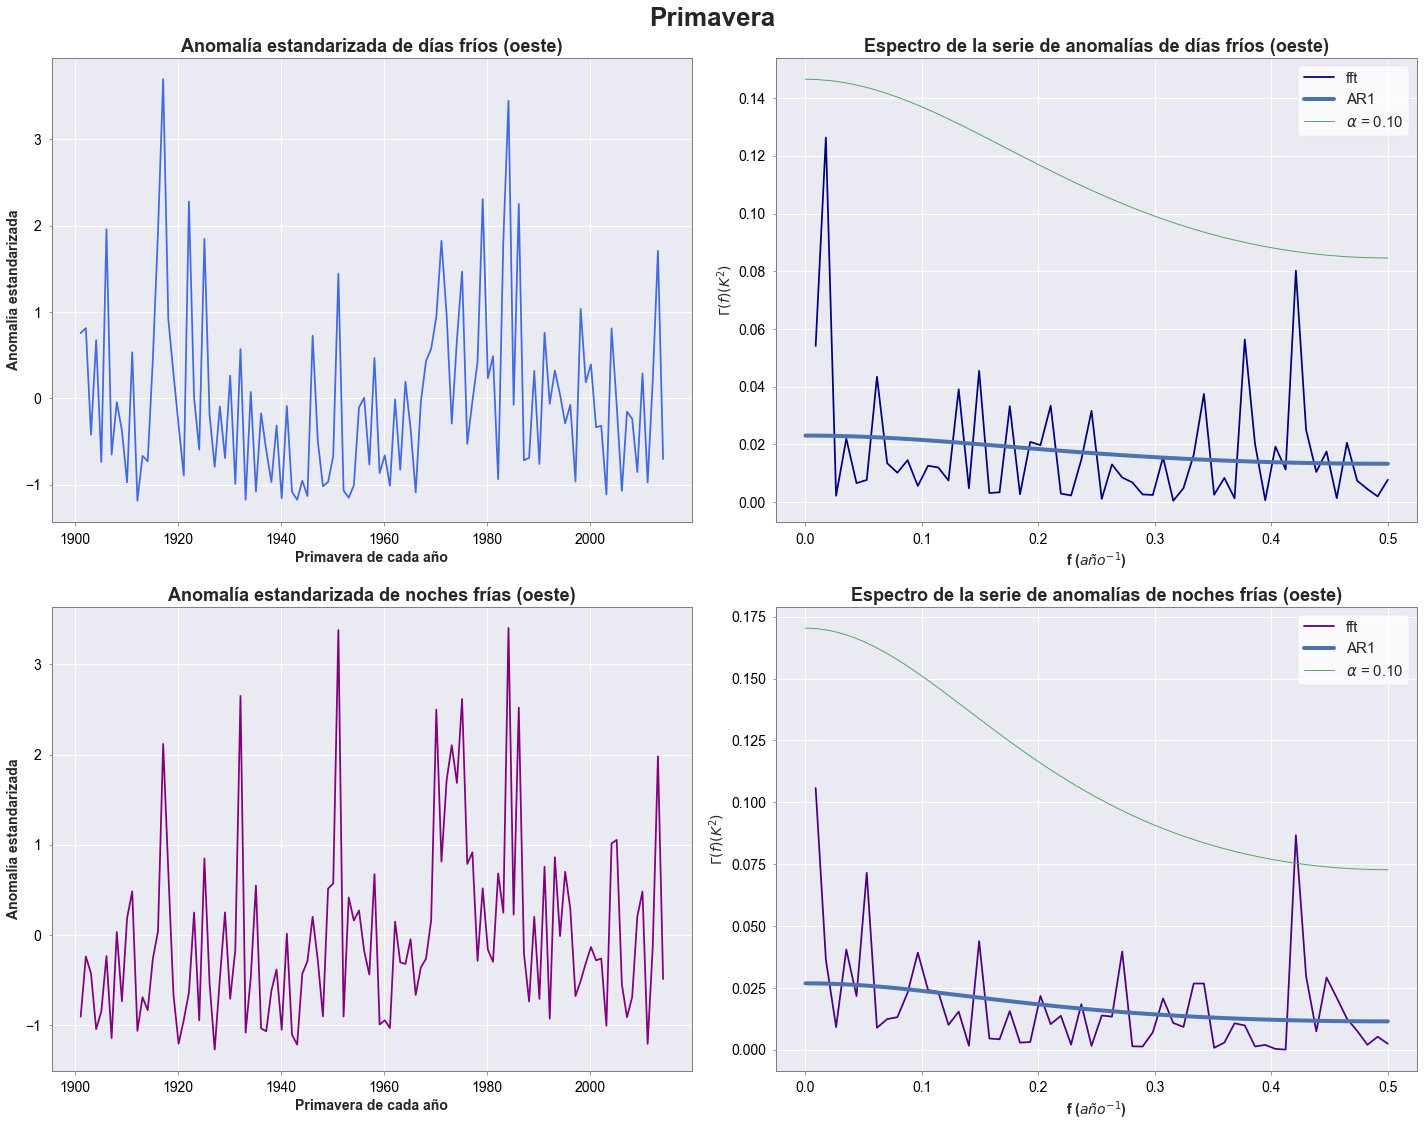

In [465]:
fig, (ax,axd) = armonics_plot(corr_O_spring,corrN_O_spring,'Primavera')

Ahora para más estaciones:

In [466]:
# Seleccionaré los demás, representadas por su primer mes: marzo
corrN_O_summer = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==6))
corr_O_summer = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==6))

corrN_O_fall = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==9))
corr_O_fall = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==9))

corrN_O_winter = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==12))
corrN_O_winter = corrN_O_winter.sel(time=slice('1901','2014')) # Hay que quitar el primero y último, no están completos
corr_O_winter = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==12))
corrN_O_winter = corr_O_winter.sel(time=slice('1901','2014')) # Hay que quitar el primero y último, no están completos

La varianza de la serie es  1.0000000000000002
La integral del espectro es  1.0025232343779324
La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0149428699331264


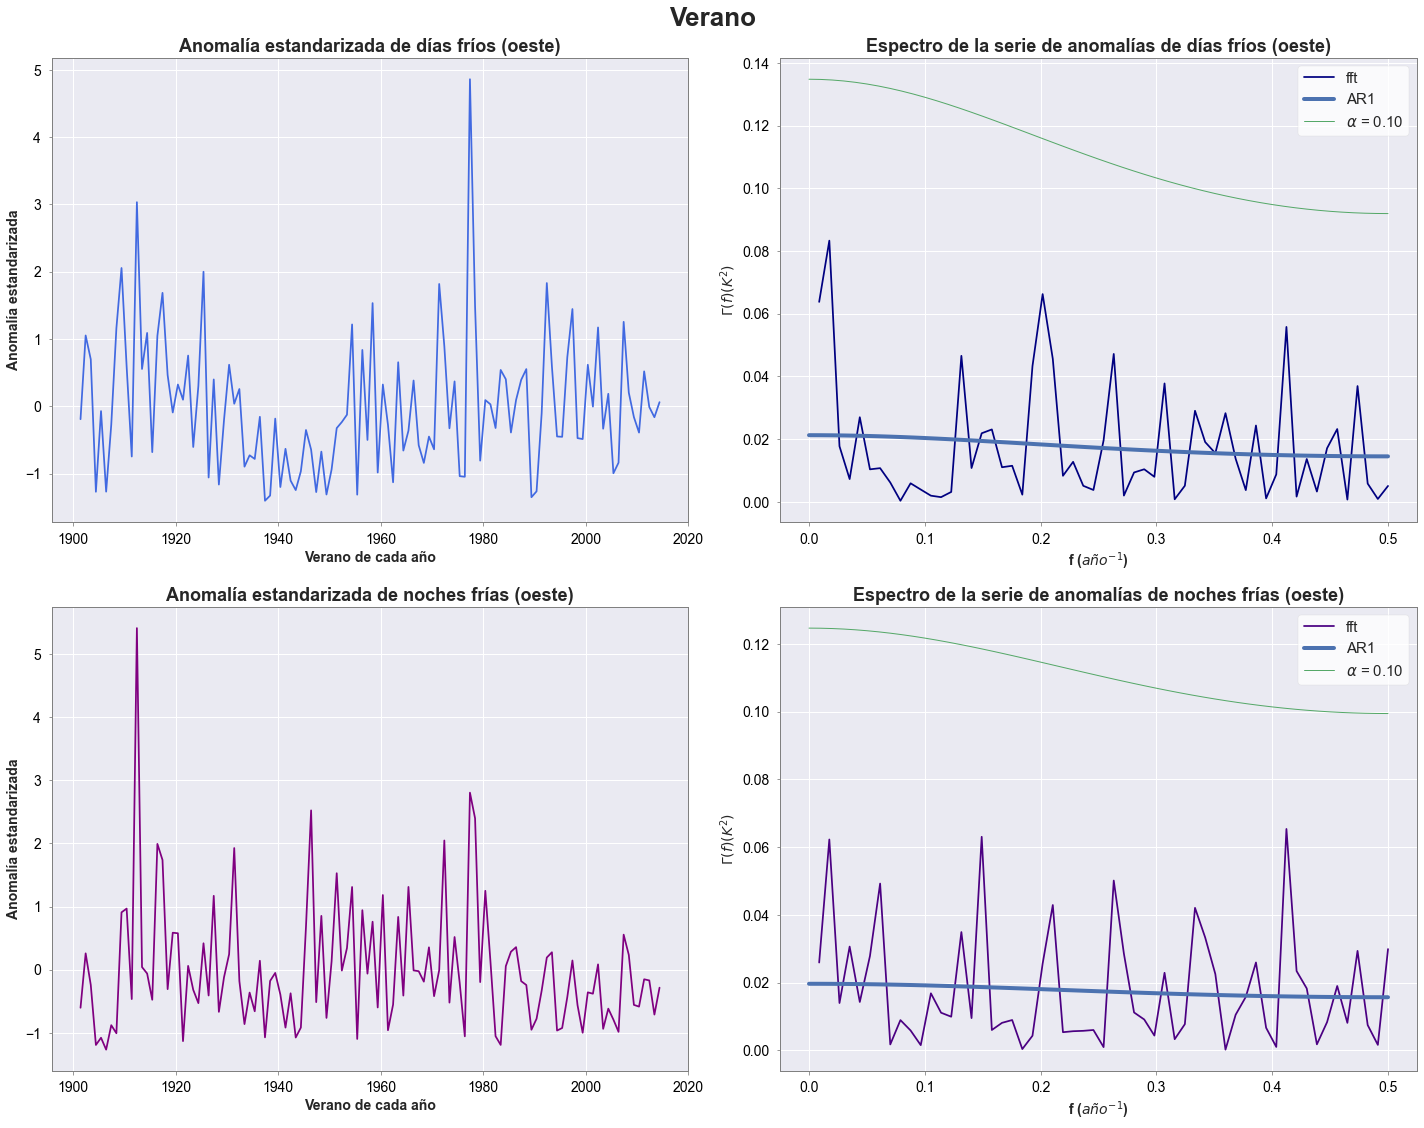

In [467]:
fig, (ax,axd) = armonics_plot(corr_O_summer,corrN_O_summer,'Verano')

La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0051272077073836
La varianza de la serie es  1.0
La integral del espectro es  1.0008989870117735


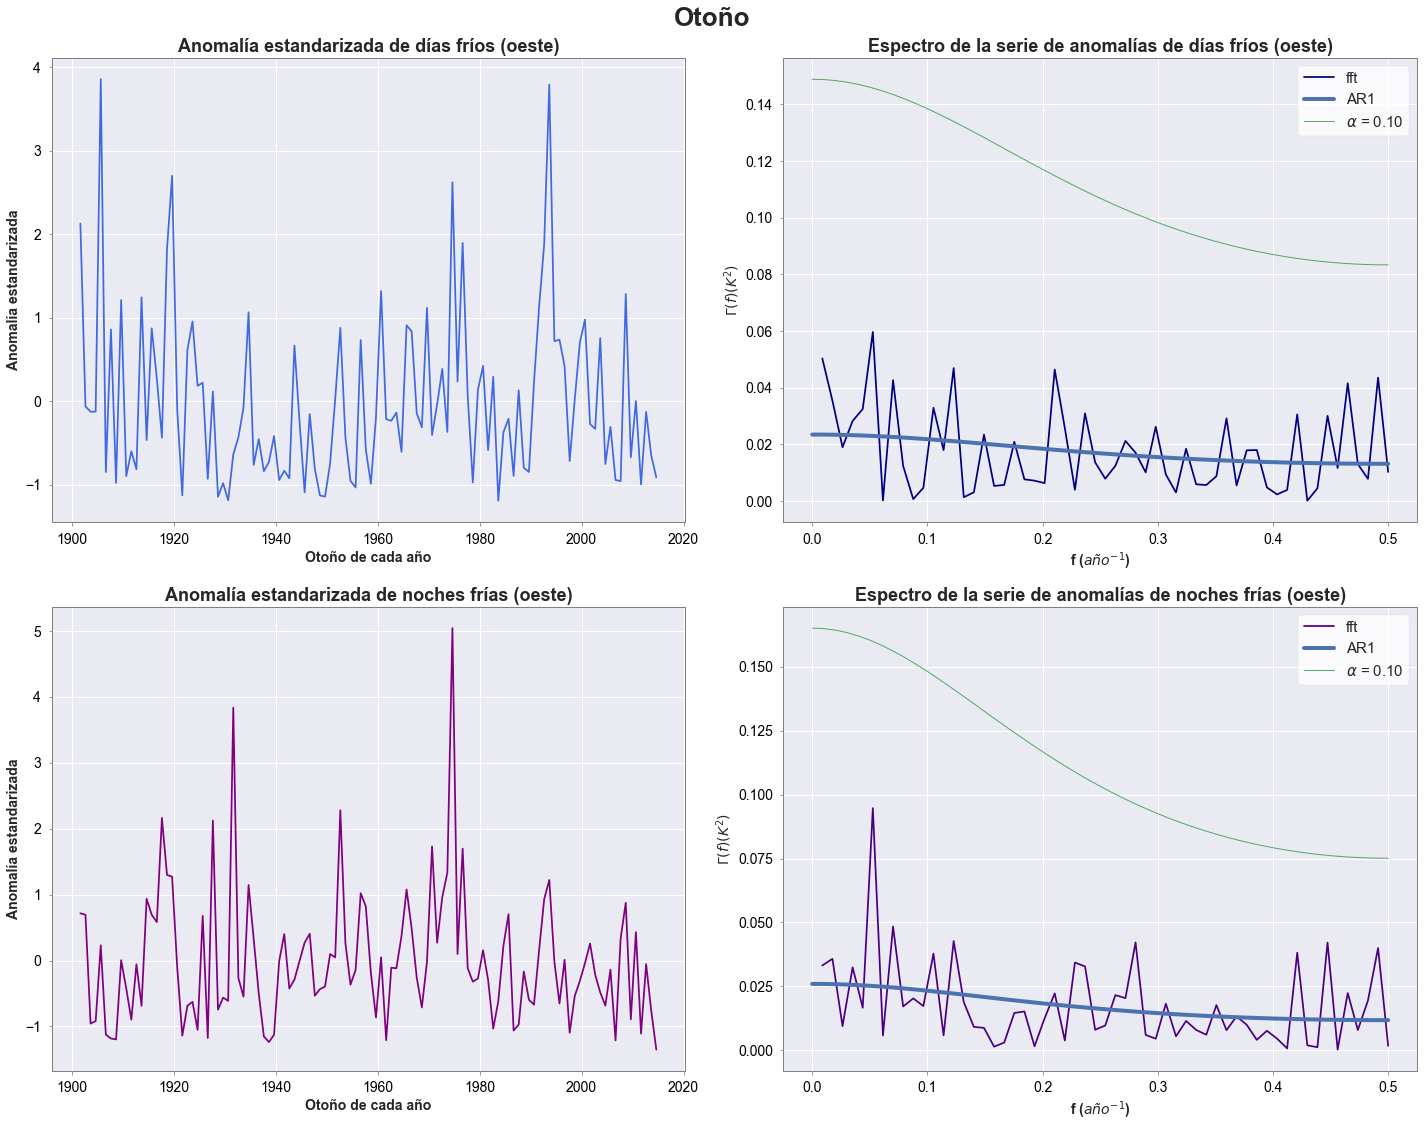

In [468]:
fig, (ax,axd) = armonics_plot(corr_O_fall,corrN_O_fall,'Otoño')

La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0051272077073836
La varianza de la serie es  1.0
La integral del espectro es  1.0008989870117735


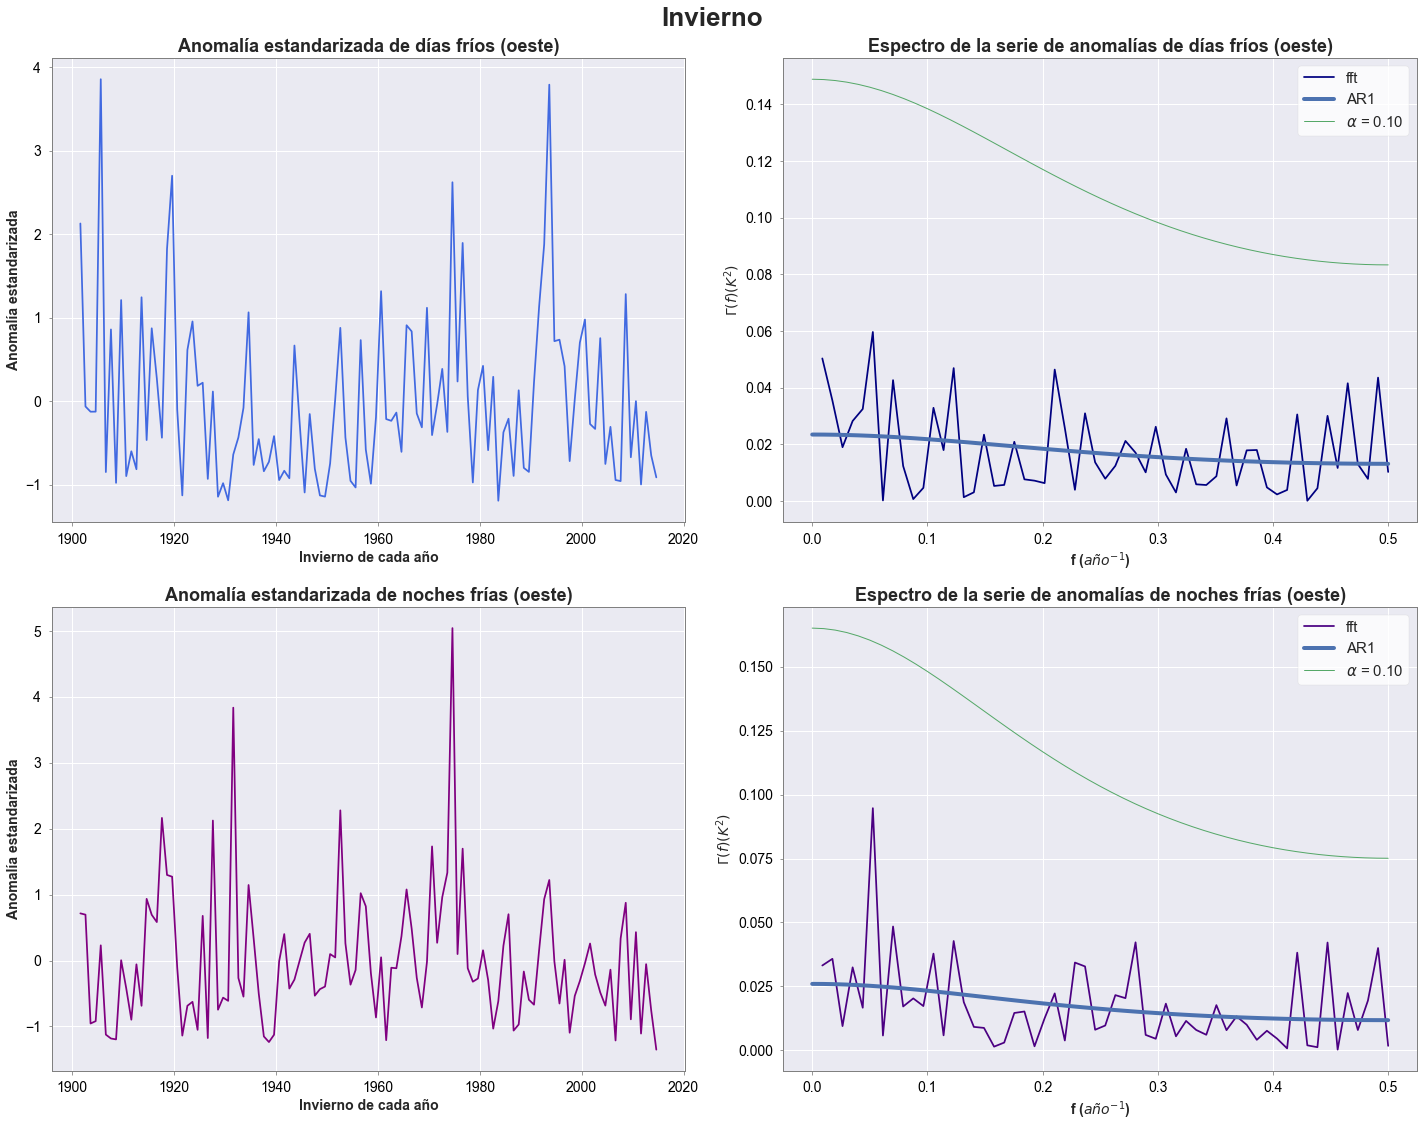

In [469]:
fig, (ax,axd) = armonics_plot(corr_O_fall,corrN_O_fall,'Invierno')

---

## Espectrograma

Voy a probar a pintar un espectrograma a ver si nos aporta algo de información:

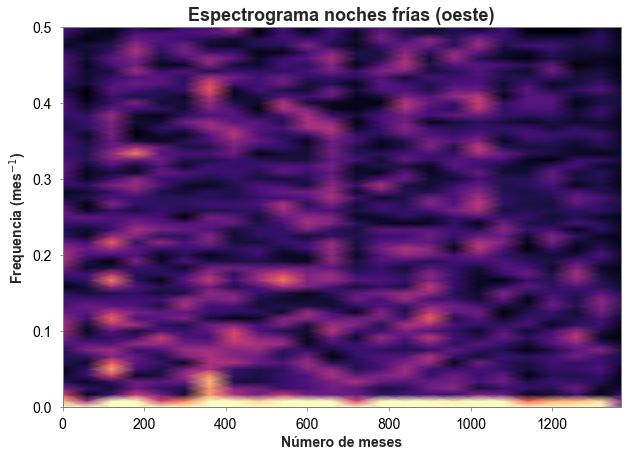

In [470]:
# Lo hago a partir del ejemplo de scipy
x=corrN_O_monthly # Para las noches 
f, t, Zxx = signal.stft(x, 1, nperseg=10*12)
Zabs = np.abs(Zxx)
fig, ax = plt.subplots(figsize=(10,7))
plt.pcolormesh(t, f, Zabs, vmin=0, vmax=Zabs.max()/3,cmap='magma', shading='gouraud')
plt.title('Espectrograma noches frías (oeste)')
plt.ylabel(r'Frequencia (mes$^{-1}$)')
plt.xlabel('Número de meses')
ax.set_xlim(0,corrN_O_monthly.size)
plt.show()

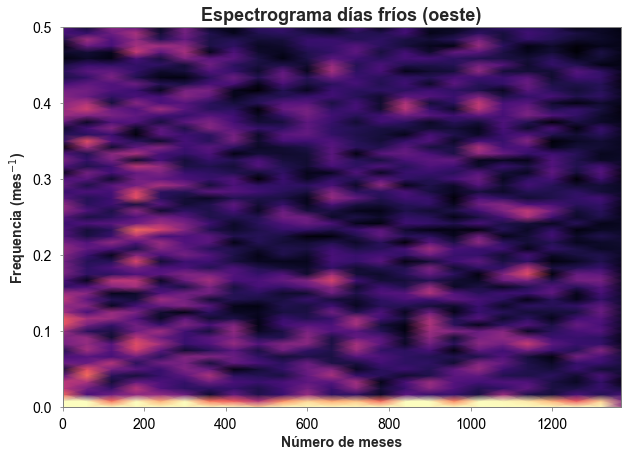

In [471]:
# Lo hago a partir del ejemplo de scipy
x=corr_O_monthly # Para los días
f, t, Zxx = signal.stft(x, 1, nperseg=10*12)
Zabs = np.abs(Zxx)
fig, ax = plt.subplots(figsize=(10,7))
plt.pcolormesh(t, f, Zabs, vmin=0, vmax=Zabs.max()/3,cmap='magma', shading='gouraud')
plt.title('Espectrograma días fríos (oeste)')
plt.ylabel(r'Frequencia (mes$^{-1}$)')
plt.xlabel('Número de meses')
ax.set_xlim(0,corrN_O_monthly.size)

plt.show()

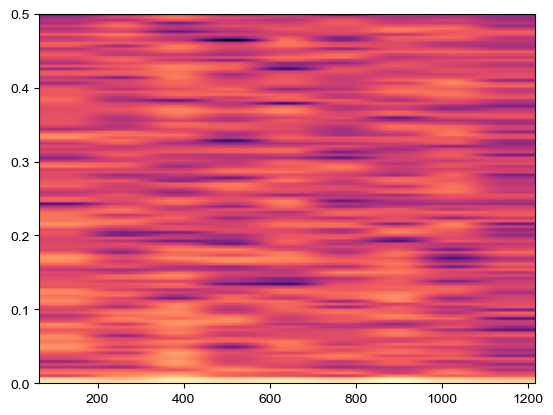

In [472]:
# Directamente con matplotlib (otros parámetros)
with plt.style.context('default'):
    plt.specgram(corrN_O_monthly,Fs=1,cmap='magma')

---

## Ajuste GEV y GPD (de los datos de temperatura)

In [473]:
# Funciones de la libreta del Tema 4
def nor(mu,sigma,x):
    #Nota: también podrías usar la función norm.pdf(x,k) del módulo stats del paquete scipy
    N=1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return N

def GEV(x,c):
    #Función que calcula la función densidad de probabilidad de Generalized Extrem Value normalizada
    # con m = 0, s = 1
    #nota: también puedes usar g=stats.genextreme.pdf(x,-c)
    if ( abs(c) < 0.005 ) :
        g = np.exp(-np.exp(-x))*np.exp(-x)
    else:
        g = ( np.power( 1 + c * x , -1-1/c) ) * np.exp( - np.power(1 + c * x ,-1/c) )
    return g

def GEVms(x,c,m,s):
    #Función que calcula la función de densidad de probabilidad Generalizada Extreme Value sin normalizar
    y = ( x - m ) / s
    if ( abs(c) < 0.005 ) :
        g = ( np.exp(-np.exp(-y))*np.exp(-y) ) / s
    else:
        g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s
    return g

def GPDs(y,c,s):
    #Función que calcula la función de densidad de probabilidad de Pareto Generalizada 
    if (abs(c)<0.0001):
        h = np.exp(-y/s)*(1/s)
    else:
        h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)
    h[y<=0]=0
    return h

def MLE_GEV(c,m,s,x):
    #Función que calcula la función likelihood sobre GEV con 
    #los parámetros de entrada c,m,s
    #y la muestra de datos x
    if ( (s < 0) | np.any(1 + c * (x-m)/s ) < 0):
        sal=1e7
    else:            
        if (abs(c) > 0.00001 ):
            t = (1 + c * (x-m)/s )**(-1/c)
        else :
            t = np.exp(-(x-m)/s)
        f = - np.log(s) + (c +1)*np.log(t) -t
        sal = f.sum()
    return -sal


def returnLevel(p, c,m,s):
    if (abs(c) > 0.00001 ):
        zp = m - ( s / c ) * ( 1 - ( - np.log( 1 - p ) ) ** ( - c ))
    else :
        zp = m - s * np.log( - np.log( 1 - p ) )
    return zp


def densityPlotGEV(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = GEVms(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad f(z)')
    ax.set_xlabel('z')
    return

def probabilityPlot(ax,pExp,pTeor):
    ax.plot([0,1],[0,1])
    ax.plot(pExp,pTeor,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Probability plot',fontsize=25)
    ax.grid()
    return

def quantilePlot(ax,xTeor,xSort):
    xTeor = -xTeor
    xSort = -xSort
    ax.plot([xSort[0],xSort[-1]],[xSort[0],xSort[-1]])
    ax.plot(xTeor,xSort,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Quantile plot',fontsize=25)
    ax.grid()
    return

def returnPlot(ax,p,zp,pExp,xSort):
    ax.semilogx(1/p,-zp)
    ax.grid()
    ax.set_xlim(1e-1,1e4)
    ax.semilogx(1/pExp,-xSort,'o')
    ax.set_title('Return level plot',fontsize=25)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Return level')
    return
    
def diagnosticsGEV(x,c,m,s):
    y = (x-m)/s
    ySort = np.sort(y)
    pExp = np.arange(1,ySort.size+1,1)/(ySort.size+1)
    pTeor = stats.genextreme.cdf(ySort,-c)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    xTeor = returnLevel(1-pExp, c,m,s)    
    p = np.logspace(-2, -1e-2, 100)
    zp=returnLevel(p,c,m,s)
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    returnPlot(ax[1,0],p,zp,pExpinv,xSort)
    densityPlotGEV(ax[1,1],x,c,m,s)
    fig.suptitle('Diagnostics',weight='bold',fontsize=25)
    
    return 

def diagnosticsGPD(x,c,m,s,numYears,invert=False):
    fig, ax = plt.subplots(2, 2, figsize=(20,15))
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    rv = stats.genpareto(c,m,s)
    pTeor = rv.cdf(xSort)
    xTeor = rv.ppf(pExp)
    fac = x.size / numYears
    p = np.logspace(-4, 2 , 100)
    zp = rv.ppf(1-p)
    fac = x.size / numYears
    returnPlot(ax[1,0],p*fac,zp,pExpinv*fac,xSort)
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    densityPlotGPD(ax[1,1],x,c,m,s)
    fig.tight_layout
    return (fig,ax)

def densityPlotGPD(ax,x,c,m,s):
    n, bins, dummy = ax.hist(-x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = stats.genpareto.pdf(-x_x,c,m,s)
    ax.plot(x_x,y_y,'r',linewidth = 4, label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad h(x)')
    ax.set_xlabel('x')
    ax.set_title('Density plot',fontsize=25)
    return

Primero para las máximas:

In [474]:
# Usaré los valores medios de temperatura minima y máxima de la región
tmaxOm = tmaxO.mean(dim=['lon','lat'],keep_attrs=True)


100yr-return value=5.188


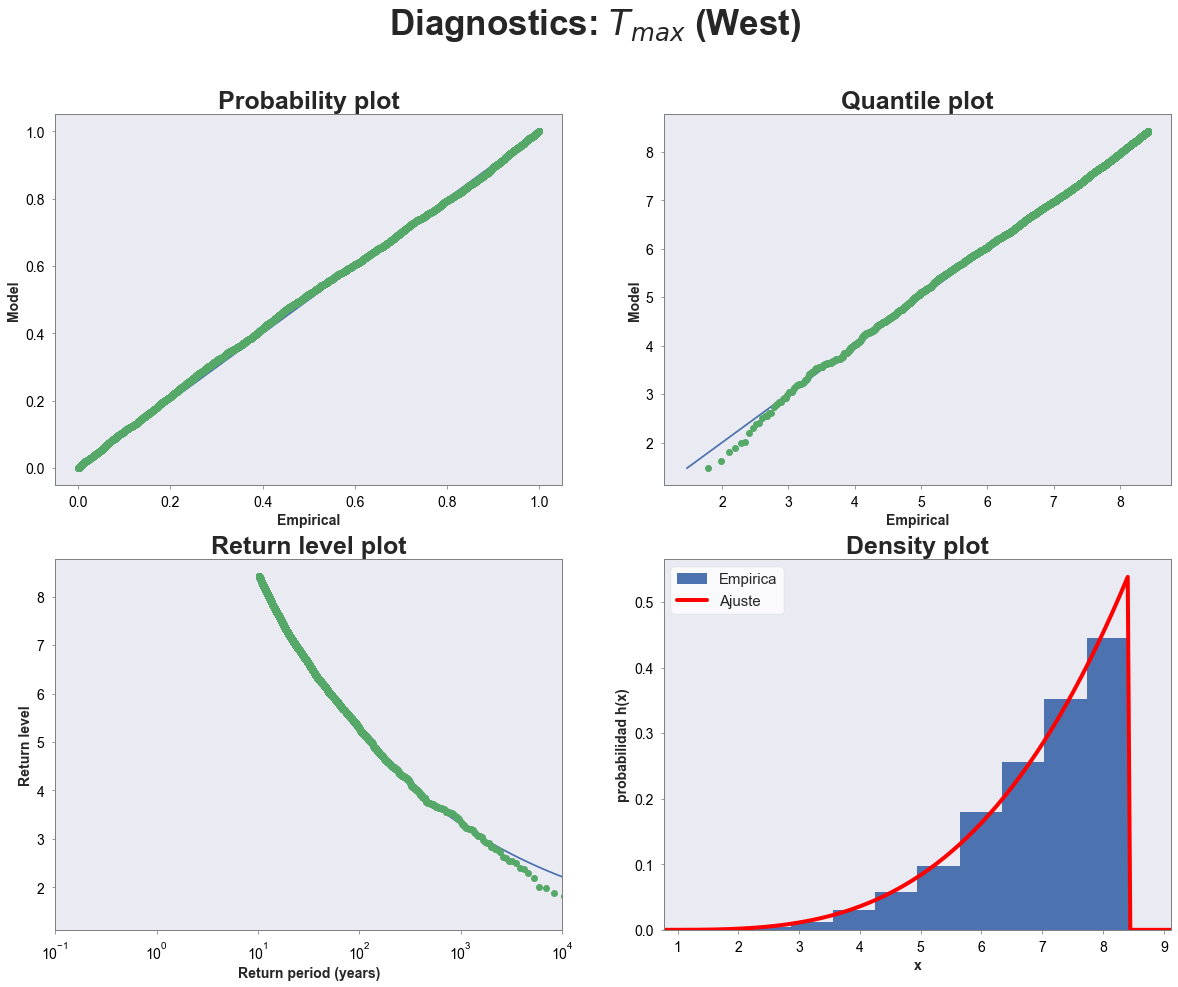

In [475]:
# Seleccion del umbral: cogeremos el percentil 10
x=-tmaxOm # Pongo un - ya que queremos calcular el periodo de retorno no del máximo sino del mínimo
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle(r'Diagnostics: $T_{max}$ (West)',weight='bold',fontsize=35)
# print('c='+'%.3f'%(c))
# print('m='+'%.3f'%(m))
# print('s='+'%.3f'%(s))
# print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

100yr-return value=-2.256


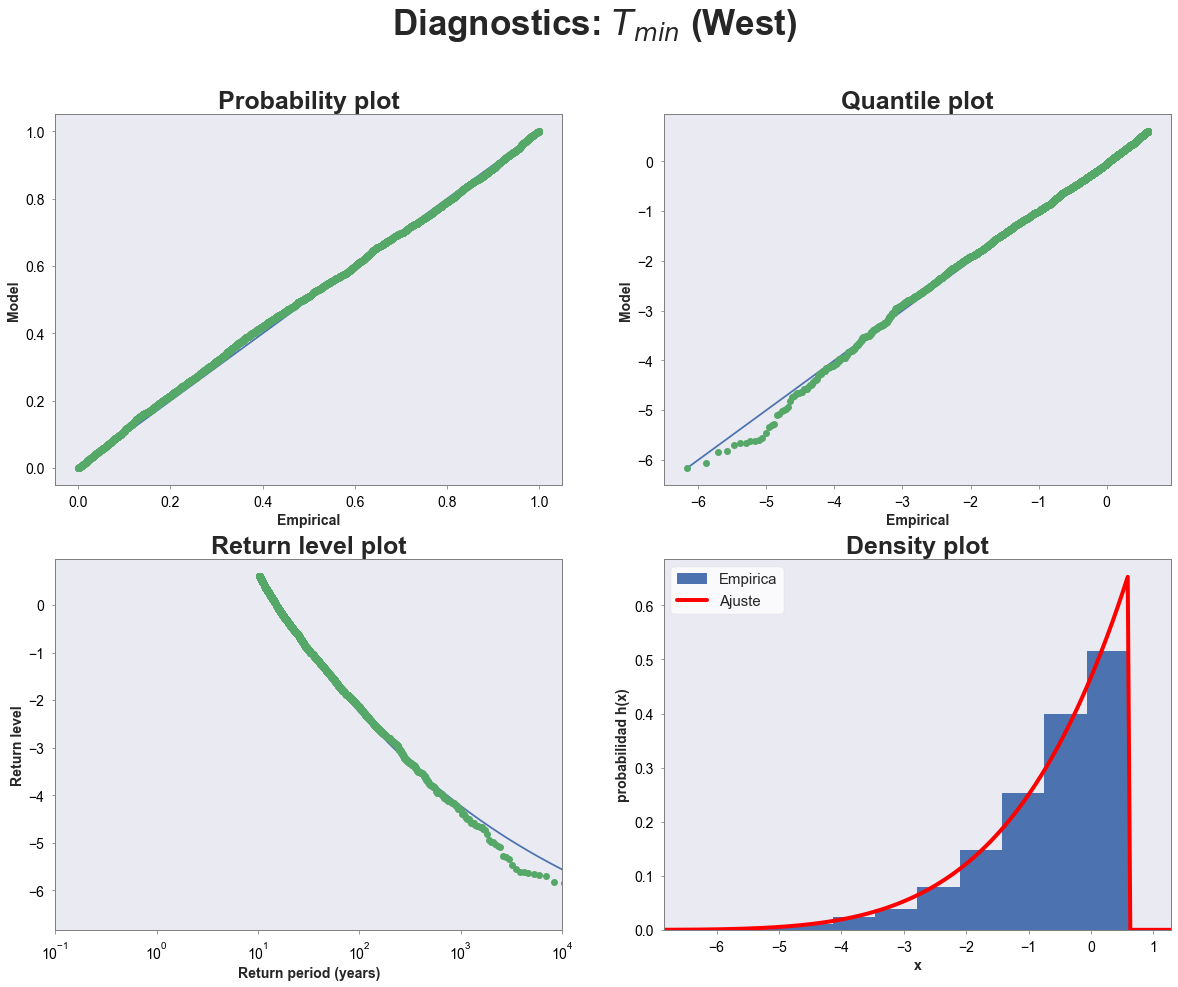

In [476]:
# Seleccion del umbral: cogeremos el percentil 10
x=-tminOm # Pongo un - ya que queremos calcular el periodo de retorno no del máximo sino del mínimo
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle(r'Diagnostics: $T_{min}$ (West)',weight='bold',fontsize=35)
# print('c='+'%.3f'%(c))
# print('m='+'%.3f'%(m))
# print('s='+'%.3f'%(s))
# print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

---

## Autocorrelación

Veamos como es la autocorrelación de cada una de las series

### Con las series mensuales:

Lo voy a hacer para la serie mensual de noches frías:

Text(0, 0.5, '$T_{n+\\tau}$')

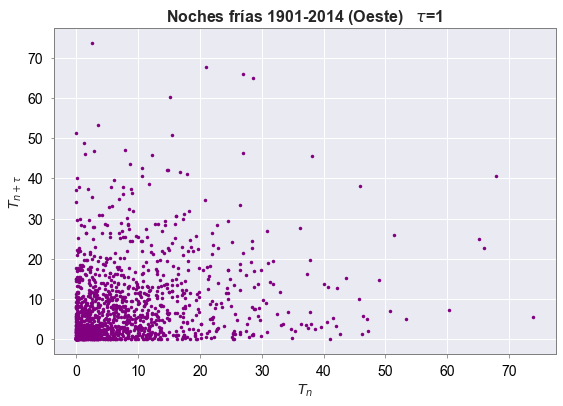

In [477]:
# Primero un plot con un solo lag
series_style()
fig,ax = plt.subplots(1,1,figsize=(9,6))
var = corrN_O_monthly
N = var.size
j = 1 #lag
ax.plot(var[0:N-j],var[j:N],'.',color='purple')
ax.set_xlabel(r'$T_n$',fontsize=14)
ax.set_title(r'Noches frías 1901-2014 (Oeste)   $\tau$='+str(j),fontsize=16, weight = 'bold')
ax.set_ylabel(r'$T_{n+\tau}$',fontsize=14)

In [478]:
#fig.savefig('scatter_n.png',dpi=300,facecolor='w')

(0.0, 480.0)

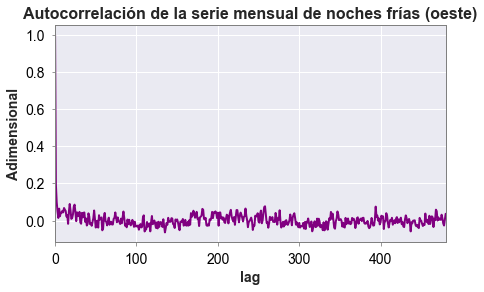

In [479]:
# Ahora la autocorrelación
nlag = 40*12 #Número de lags para los que queremos calcular la autocovarianza

co_mn = stattools.acf(var,fft=False, nlags = nlag) * N/(N-1)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(co_mn,linewidth=2,color='purple')
ax.set_title('Autocorrelación de la serie mensual de noches frías (oeste)', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])
#ax.set_xlim([0,14])

Y con los días:

Text(0, 0.5, '$T_{n+\\tau}$')

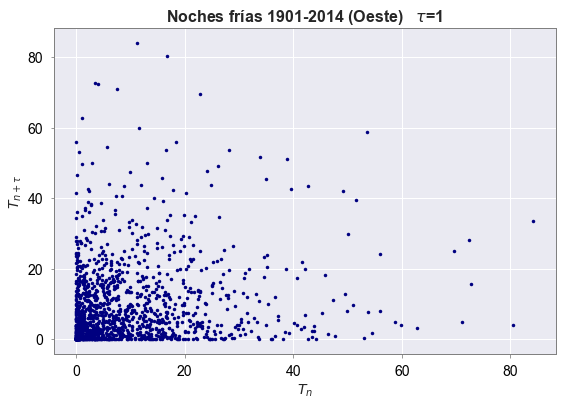

In [480]:
# Primero un plot con un solo lag
fig,ax = plt.subplots(1,1,figsize=(9,6))
var = corr_O_monthly
N = var.size
j = 1
ax.plot(var[0:N-j],var[j:N],'.',color='navy')
ax.set_xlabel(r'$T_n$',fontsize=14)
ax.set_title(r'Noches frías 1901-2014 (Oeste)   $\tau$='+str(j),fontsize=16, weight = 'bold')
ax.set_ylabel(r'$T_{n+\tau}$',fontsize=14)

In [481]:
#fig.savefig('scatter_d.png',dpi=300,facecolor='w')

(0.0, 480.0)

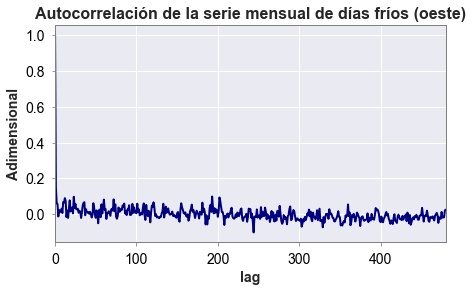

In [482]:
# Ahora la autocorrelación
co_md = stattools.acf(var,fft=False, nlags = nlag) * N/(N-1)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(co_md,linewidth=2,color='navy')
ax.set_title('Autocorrelación de la serie mensual de días fríos (oeste)', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])

Voy a representarlas dos series junto con ruido blanco para ver su similitud:

(0.0, 480.0)

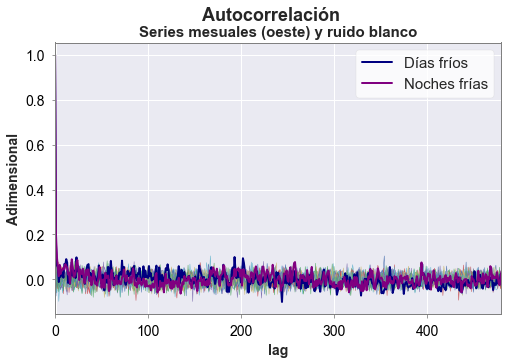

In [483]:
# Construimos las series de ruido
rng = np.random.default_rng()
mu, sigma = 0, 2

#Las construyo tan largas como la serie que trabajábamos
fig,ax = plt.subplots(1,1,figsize=(8,5))

ax.axhline(y=0,color='w',linewidth=4)
ax.axvline(x=0,color='w',linewidth=4)

for i in range(20): # 20 series de ruido blanco 
    x1 = rng.normal(mu,sigma,var.size)
    cox1 = stattools.acf(x1, fft=False, nlags = nlag) * N/(N-1)
    ax.plot(cox1,linewidth=0.5) # Plots del ruido

ax.set_title('Autocorrelación', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])


# Plot de las series 
ax.plot(co_md,linewidth=2,color='navy',label='Días fríos')
ax.plot(co_mn,linewidth=2,color='purple',label='Noches frías')
fig.suptitle('Autocorrelación',fontsize=18,weight='bold')
ax.set_title('Series mesuales (oeste) y ruido blanco', fontsize=15,weight='semibold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.legend()
ax.set_xlim([0,nlag])

In [484]:
# fig.savefig('autocorr_m.png',dpi=300,facecolor='w')

### Con las series anuales:

Text(0, 0.5, '$T_{n+\\tau}$')

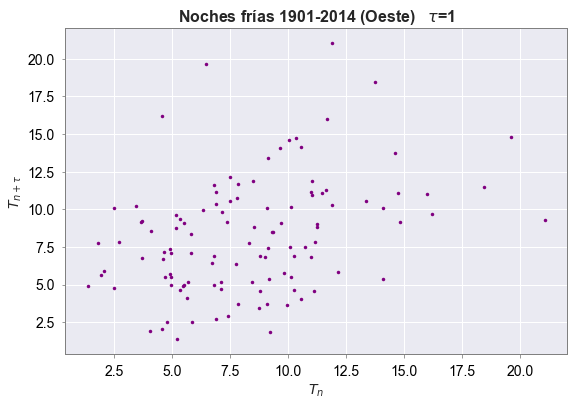

In [485]:
# Primero un plot con un solo lag
fig,ax = plt.subplots(1,1,figsize=(9,6))
var = corr_O
N = var.size
j = 1
ax.plot(var[0:N-j],var[j:N],'.',color='purple')
ax.set_xlabel(r'$T_n$',fontsize=14)
ax.set_title(r'Noches frías 1901-2014 (Oeste)   $\tau$='+str(j),fontsize=16, weight = 'bold')
ax.set_ylabel(r'$T_{n+\tau}$',fontsize=14)

In [486]:
# fig.savefig('scatter_na.png',dpi=300,facecolor='w')

(0.0, 113.0)

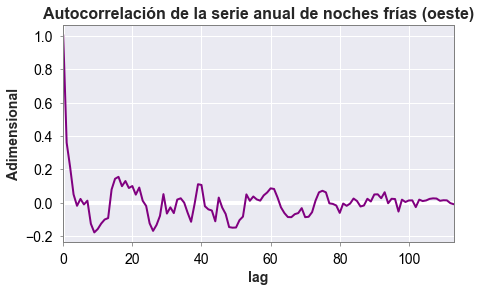

In [487]:
nlag = 114-1 #Número de lags para los que queremos calcular la autocovarianza

co_an = stattools.acf(var,fft=False, nlags = nlag) * N/(N-1)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.axhline(y=0,color='w',linewidth=4)
ax.axvline(x=0,color='w',linewidth=4)


ax.plot(co_an,linewidth=2,color='purple')
ax.set_title('Autocorrelación de la serie anual de noches frías (oeste)', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])

Y ahora con los días fríos:

Text(0, 0.5, '$T_{n+\\tau}$')

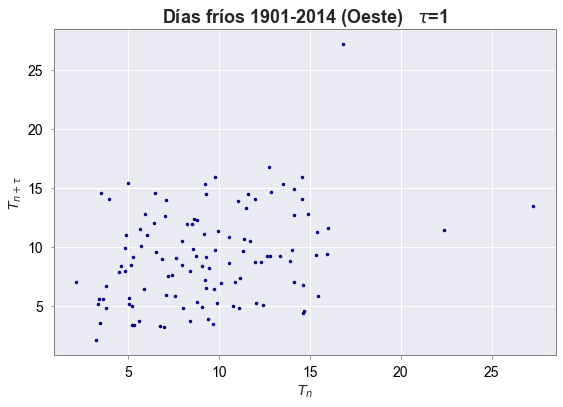

In [488]:
# Primero un plot con un solo lag
fig,ax = plt.subplots(1,1,figsize=(9,6))
var = corr_O_d
N = var.size
j = 1
ax.plot(var[0:N-j],var[j:N],'.',color='navy')
ax.set_xlabel(r'$T_n$')
ax.set_title(r'Días fríos 1901-2014 (Oeste)   $\tau$='+str(j), weight = 'bold')
ax.set_ylabel(r'$T_{n+\tau}$')

In [489]:
# fig.savefig('scatter_da.png',dpi=300,facecolor='w')

(0.0, 113.0)

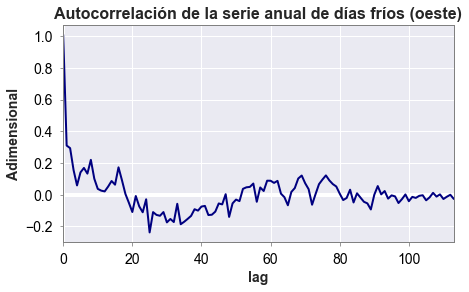

In [490]:
nlag = 114-1 #Número de lags para los que queremos calcular la autocovarianza

co_ad = stattools.acf(var,fft=False, nlags = nlag) * N/(N-1)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.axhline(y=0,color='w',linewidth=4)
ax.axvline(x=0,color='w',linewidth=4)


ax.plot(co_ad,linewidth=2,color='navy')
ax.set_title('Autocorrelación de la serie anual de días fríos (oeste)', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])

Voy a representarlas dos series junto con ruido blanco para ver su similitud:

(0.0, 113.0)

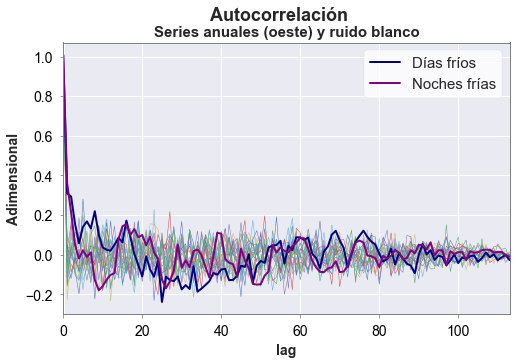

In [491]:
%matplotlib inline

# Construimos las series de ruido
rng = np.random.default_rng()
mu, sigma = 0, 2

#Las construyo tan largas como la serie que trabajábamos
fig,ax = plt.subplots(1,1,figsize=(8,5))

ax.axhline(y=0,color='w',linewidth=4)
ax.axvline(x=0,color='w',linewidth=4)

for i in range(20): # 20 series de ruido blanco 
    x1 = rng.normal(mu,sigma,var.size)
    cox1 = stattools.acf(x1, fft=False, nlags = nlag) * N/(N-1)
    ax.plot(cox1,linewidth=0.5) # Plots del ruido

ax.set_title('Autocorrelación', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])


# Plot de las series 
ax.plot(co_ad,linewidth=2,color='navy',label='Días fríos')
ax.plot(co_an,linewidth=2,color='purple',label='Noches frías')
fig.suptitle('Autocorrelación',fontsize=18,weight='bold')
ax.set_title('Series anuales (oeste) y ruido blanco', fontsize=15,weight='semibold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.legend()
ax.set_xlim([0,nlag])


In [492]:
# fig.savefig('autocorr_a.png',dpi=300,facecolor='w')

=> La serie es prácticamente ruido sin memoria.